<a href="https://colab.research.google.com/github/shirleytingyen/MystanCodeProjects/blob/main/Day02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 諸注意

- 本講座は金融取引に対する理論的かつ実践的な学びを提供するものですが、各自で実運用する際の利益を確約するものではありません

- 配布する資料について、情報の正確性について万全を期しておりますが、その内容について保証するものではありません

- 他の受講生や運営への迷惑行為は禁止

- 受講生以外への講義資料・講義動画の共有は固く禁止します
  - 禁止事項の例
    - SNSへのアップロード
    - Githubでコードを公開

- 本講義の内容についてSNSに投稿するのはお控えください


## 参考、リンクなど

[1] マルコス・ロペス・デ・プラド (著), 長尾 慎太郎 (監修, 翻訳), 鹿子木 亨紀 (監修, 翻訳), 大和アセットマネジメント (翻訳) 「ファイナンス機械学習―金融市場分析を変える機械学習アルゴリズムの理論と実践」 きんざい, 2019.

[2] [ファイナンス機械学習著者による解説スライド](https://quantresearch.org/Lectures.html)

[3] [[2]について日本語の解説記事](https://quantcollege.net/%e3%80%90%e3%83%95%e3%82%a1%e3%82%a4%e3%83%8a%e3%83%b3%e3%82%b9%e6%a9%9f%e6%a2%b0%e5%ad%a6%e7%bf%92%e3%80%91%e8%91%97%e8%80%85%e3%81%ae%e8%ac%9b%e7%be%a9%e3%82%b9%e3%83%a9%e3%82%a4%e3%83%89%e3%82%92)

## 著作権について

- 本講義の教科書である,ファイナンス機械学習(AFML)書籍中の実装コードを参考にした部分については実行セル中にスニペット番号を記載しています.

- その他実装の参考にしたurl等はセル中に記載しています.

# 2. 入力設計

<章トビラ>

本章ではまず金融データについて確認した上で,アルゴリズムトレードの流れを確認します.
また,機械学習を用いたトレードアルゴリズムを作るために必要なデータの前処理の方法と基本的な時系列分析の手法について学びます.<br>
時系列データに対して必要な前処理を実施し,機械学習における$y=f(X)$の入力データ$X$部分を作成する手順を理解することを目的としています.

主にAFML2章,5章の内容です.

ゴール：金融データとは何か,金融データの特徴を理解する.アルゴリズムトレードの流れを理解する.アルゴリズムトレードに機械学習を利用するための必要な前処理とその方法を身につける.

# 事前準備
- ライブラリインポート
- driveのマウント
- 実行ディレクトリへの移動

In [ ]:
# pandasのバージョンを下げる対応
!pip install "pandas<2.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 35.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 1.5.3 which is incompatible.
xarray 2024.6.0 requires pandas>=2.0, but you have pandas 1.5.3 which is incompatible.


In [ ]:
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 45.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=5e93af5cac2ea6c85084528a426189d3d3d7f5c7ecbb7d3ab39ce066c430c8be
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


In [ ]:
# 必要ライブラリの準備
import os
import math
import gzip
from time import sleep
from random import gauss
from itertools import product
import pickle
from datetime import datetime, timedelta, date
from urllib import request
import warnings

import numpy as np
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline

warnings.simplefilter('ignore')

以下のセルを実行してドライブをマウントし実行ディレクトリへ移動します.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 以下はサンプルです.ご自身の環境に合わせてフォルダへのパスは変更してください.
%cd /content/drive/Shareddrives/finance/金融講義/Develop/2024_summer/Day02

/content/drive/Shareddrives/finance/金融講義/Develop/2024_summer/Day02


# 2.1金融データとは

ゴール：金融データの種類と特徴を知る．

金融データには大きく分けて以下4つの種類が存在します.

| 種類 | 概要 |
| --- | --- |
|ファンダメンタルデータ |　企業の財務データ(売上,利益など)や<br>円高円安の影響など経済環境に関するデータなど. <br>このデータは企業では4半期ごとに発表されるものであり更新頻度は低く,<br>市場へ反映されやすいためこのデータ単体では利用価値はあまり残っていない.|
|市場データ| 取引所での取引価格,出来高など取引市場から得られるデータ |
|アナリティクスデータ| 投資銀行やリサーチ会社から発表される分析済みのデータ<br> ニュース報道やファンダメンタルデータに対しての分析と重要情報が抽出されたデータ|
|オルタナティブデータ| 上記のいずれにも該当しないデータ(SNSから得られるデータや<br>ニュース情報,天気,交通量などの生のデータを指す)<br>取り扱いが難しい反面,新たな発見につながる可能性がある. |

アルゴリズムトレードではこのようなデータをリアルタイムに利用し売買判断を行います.

本章では**市場データ**に該当する仮想通貨取引所の[bybit](https://www.bybit.com/ja-JP/)の約定履歴データからバー形式と呼ばれる構造化された形式のデータを作成します.

特に価格の推移のデータについてはローソク足チャートと呼ばれる形に変形することができます.ローソク足チャートとは一定のルールで約定履歴データから始値, 高値, 安値, 終値の４つの値をサンプリングし一本の棒状の足(ローソク足)として並べたものです.

bybit USDBTCのローソク足チャート [参考] https://www.bybit.com/ja-JP/trade/spot/BTC/USDT

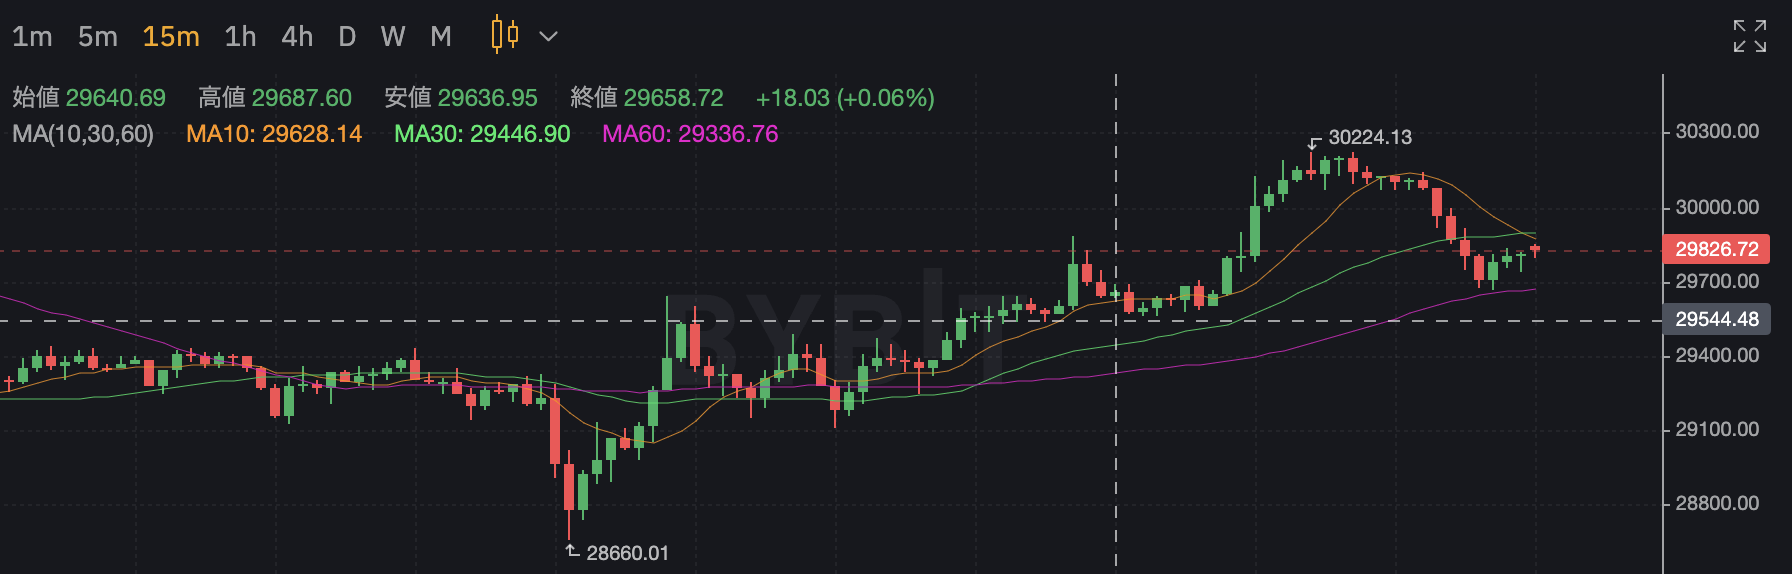

ローソク足について[参考] https://www.sevendata.co.jp/shihyou/technical/rosoku01.html

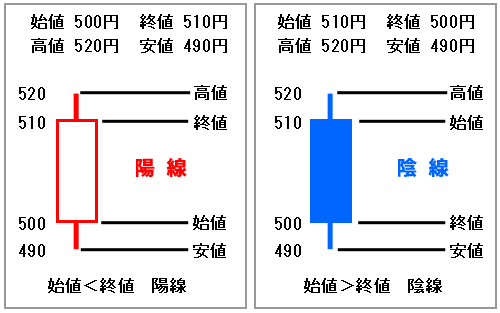

## bybit約定データの準備

bybitからダウンロードできる約定履歴データのうち2022年3月1日~2022年3月31日の1ヶ月間のデータをpickle形式で用意しています.
(取引所の公開しているデータにapi経由でアクセスしダウンロードする関数はAppendixに用意しています.)

まずはこのデータを読み込みます.
データは[こちら](https://public.bybit.com/trading/)からダウンロードしたものです.
通貨ペアは*BTCUSD*です.

In [ ]:
# pickleデータの読み込み(場合によってはファイルへのパスを変更していただく必要があります.)
# こちらのpickleファイルはDay02フォルダ以下に配置されているものです.
with open("./bybit_BTCUSD_2022_3.pkl", mode="rb") as f:
  exec_data = pickle.load(f)
# bybit約定履歴にはunixタイムスタンプとして時刻情報が記録されているため,これを日付に変換している.
# unixタイムスタンプとは1970年1月1日午前00:00:00(UTC)からの経過秒数を表す.
exec_data["timestamp"] = pd.to_datetime(exec_data["timestamp"], unit="s")
exec_data.set_index("timestamp", inplace=True)
exec_data.head()

symbol  side  size    price  tickDirection  \
timestamp                                                
2022-03-01  BTCUSD  Sell     9  43179.5      MinusTick   
2022-03-01  BTCUSD  Sell     3  43179.5  ZeroMinusTick   
2022-03-01  BTCUSD  Sell     2  43179.5  ZeroMinusTick   
2022-03-01  BTCUSD  Sell     1  43178.5      MinusTick   
2022-03-01  BTCUSD  Sell     1  43178.0      MinusTick   

                                      trdMatchID    grossValue  homeNotional  \
timestamp                                                                      
2022-03-01  876d94ec-9f6a-528f-9648-55c6133e19d6  20843.224215             9   
2022-03-01  b94b11dc-7747-50c5-9590-a732ab859939   6947.741405             3   
2022-03-01  2c833623-2598-57fa-8408-92900ffdc90f   4631.827603             2   
2022-03-01  ce18bf17-3535-534d-8745-bafb1267de27   2315.967437             1   
2022-03-01  29f8b6bf-066f-59c2-83b5-fe63a3739954   2315.994256             1   

            foreignNotional  
timestamp                    
2022-03-01         0.000208  
2022-03-01         0.000069  
2022-03-01         0.000046  
2022-03-01         0.000023  
2022-03-01         0.000023

In [ ]:
# データ数
len(exec_data)

11921083

2022年3月1日~2022年3月31日の1ヶ月間のにbybitのBTCUSDの取引では11,921,083件の約定があったことがわかります.

## exec_dataの確認

| 列 | 詳細 |
| --- | --- |
| timestamp | 約定の時刻. |
| symbol | 取引通貨ペア.　今回はBTCUSD. |
| side | 注文のsideを表す. 売り(SELL)か買い(BUY)の2種類.<br>今回のペアでは買いの場合BTCをUSDで買うことを表す. |
| size | 注文量(出来高). 今回のBTCUSDぺアでは単位はUSD. |
|price| 約定時の価格.今回の場合1BTCのドル価格を表す. |
| tickDirection | 以下4種類ありその注文による取引所での価格の変化の方向を表す.<br>1. ZeroMinusTick<br>2. MinusTick<br>3. PlusTick<br>4. ZeroPlusTick<br><li>minus/plus<br>minusの場合は売りの成り行き注文より直前の価格よりも取引価格が低下<br>plusの場合は買いの成り行き注文より直前の価格よりも取引価格が上昇<li>zero<br>直前の取引と価格が変化しなかった場合 |
| trdMatchID |  約定のid |
| grossValue | satoshi単位での出来高.foreignNational * 100,000,000 |
| homeNational | USDでの出来高を表す. 今回の取引ペアではsizeの値と一致する. |
| foreignNational |  BTCでの出来高. |

約定履歴のデータの内容が確認できましたがこのデータは構造化されておらず機械学習に利用することが難しいです.次節では構造化されたバー形式への変換を実施します.<br>
本講義では時刻をindex, 列に始値, 高値, 安値, 終値, 取引高(合わせてohlcv形式とも呼ばれます.)の5つの列を持つテーブル形式のデータ(バー形式)を作成します.

# 2.2 バー形式データの作成

ゴール：非構造化データである約定履歴のデータからバー形式と呼ばれる構造化データを作成する.

## 2.2.1 タイムバー

最も一般的な形式であり多くの取引所からダウンロードできる価格データも基本的にタイムバー形式に加工されている場合が多いです.

本講義において実施されるトレードコンペティションにおいても基本的にはこちらのタイムバーを入力データとして利用していただきます.

タイムバーは一定時間ごとに(1分ごと,1日ごとなどそれぞれ分足,日足と呼ばれます)約定のデータをサンプリングした形式を表します.

この形式は作成が容易であり広く利用されていますが以下の問題点が挙げられます.

1. 注文が多い時刻, 少ない時刻に関係なくサンプリングしてしまう.そのため注文が多い時刻には過小にサンプリング, 少ない時刻には過剰にサンプリングしてしまう.
2. 1.の問題により統計的性質が好ましくない場合がある.

上記のような問題点がある一方, 実運用を想定した際作成と利用が容易であるという点から今回はこちらのタイムバーを基準として進めます.

In [ ]:
#　サンプリング期間 15分間隔のタイムバーを作成
FREQ = "15min"
# ohlcvの列を持ったテーブルデータ他形式のバーも同様の列を持つ
time_bar = pd.DataFrame(columns=["op", "hi", "lo", "cl", "volume"])
time_bar.index.name = "timestamp"

ohlc = exec_data["price"].resample(FREQ).ohlc()
volume = exec_data["size"].resample(FREQ).sum()
ohlcv = pd.concat([ohlc, volume], axis=1)
ohlcv.index.name = "timestamp"
ohlcv.columns = ["op", "hi", "lo", "cl", "volume"]

time_bar = pd.concat([time_bar, ohlcv], axis=0)

time_bar.head()

op       hi       lo       cl    volume
timestamp                                                        
2022-03-01 00:00:00  43179.5  43593.0  43177.0  43367.0  39018957
2022-03-01 00:15:00  43367.0  43384.0  43198.5  43367.0   9372331
2022-03-01 00:30:00  43367.5  43541.5  43318.5  43524.5  22522912
2022-03-01 00:45:00  43524.5  43745.0  43341.5  43549.5  27202334
2022-03-01 01:00:00  43549.5  43620.0  43279.0  43294.0  13692174

- タイムバーのプロット

Text(0.5, 1.0, 'タイムバー')

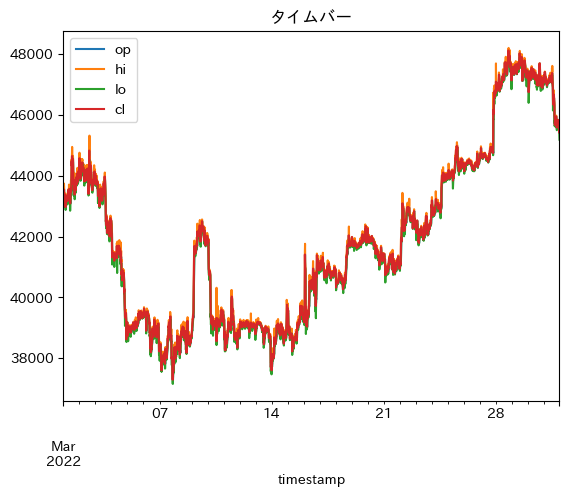

In [ ]:
time_bar[["op","hi","lo","cl"]].plot()
plt.title("タイムバー")

- タイムバーの価格リターン(終値系列の変化率)のヒストグラム

終値価格系列を$p_t$, リターン系列$r_t$を
$$
r_t = \frac{p_{t+1}}{p_t} - 1
$$
として$r_t$のヒストグラムを確認します.

<Axes: title={'center': 'リターンのヒストグラム'}>

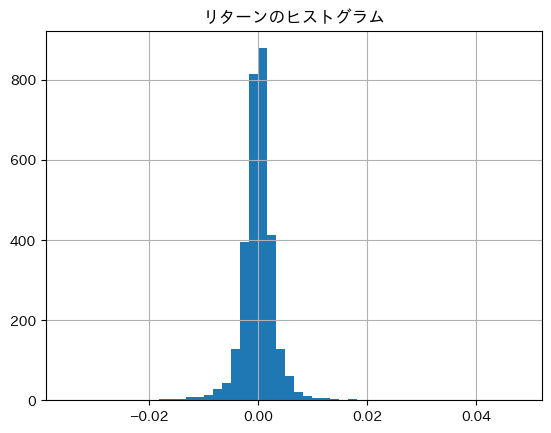

In [ ]:
plt.title("リターンのヒストグラム")
time_bar["cl"].pct_change().hist(bins=50)

ヒストグラムからも確認できる通り, タイムバーのリターンの分布は正規分布と比較すると尖度の高い形状をしていることが確認できます.

## 2.2.2 タイムバー以外のバー形式について

タイムバーの統計的な性質の問題などに対応するため以下のようなバー形式も存在します.

- ボリュームバー
- ティックバー
- ドルバー

それぞれの詳細や統計的な性質の確認についてはAppendix(別ノートブック)に記載しています.

In [ ]:
# 以下からはtime_barを利用します.
# メモリの節約のため,約定データは削除します.
del exec_data

# 2.3 アルゴリズムトレードのパイプライン

ゴール:タイムバー形式のデータからどのような流れでトレードを実行するか理解する.

アルゴリズムトレードを実行する際のパイプラインは以下の図のようになります.

[参考] https://arxiv.org/pdf/2206.14932v1.pdf

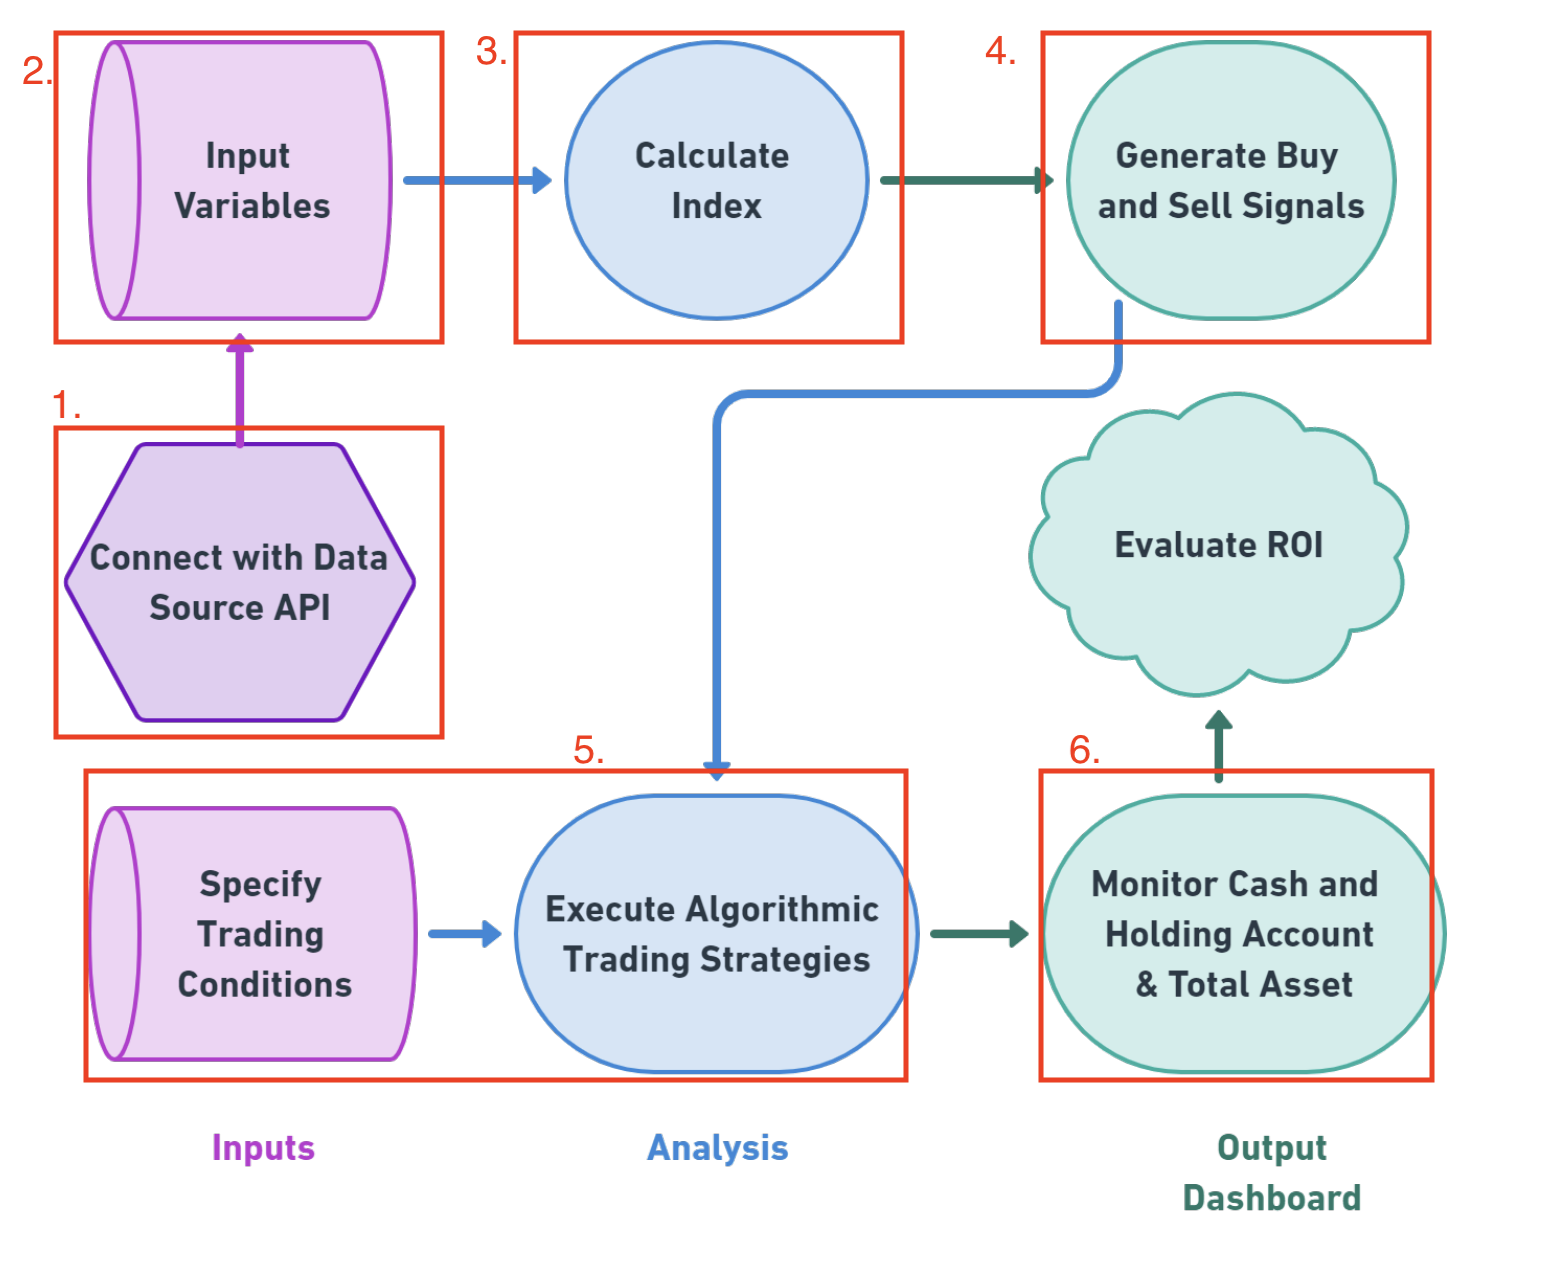

2.2節で確認した,1分,1時間など一定の時間間隔で取引所からタイムバー形式のohlcvのデータを受け取ります.一定間隔で受け取ったデータ(タイムバーデータ)について次のような手順で発注を行います.

1. Connect with Data Source API

 取引所データを受け取る設定をしています.

2. Input Variables

 今回の設定では取引所から15minの間隔でデータを受け取ります.(タイムバーohlcv)

3. Calculate Index

 ohlcvデータに対して分析用の前処理を実施します.

4. Generate Buy and Sell Signals

 処理されたデータを入力に売買の判断として「シグナル」の作成を行います. この部分で機械学習を用いてシグナルの作成を行うことを目指します.

5. Specify Trading Conditions

 自身がその時点で保有している現金や保持しているポジションサイズを参照します.

6. Execute Algorithmic Trading Strategies

 5. の情報と, 4.で作成したシグナルの情報をもとに注文を実行します.

# 2.4 時系列データ分析

ゴール:一般的な時系列分析の手法について学ぶ.機械学習を利用する場合の注意点などについて理解する.

2.4節では2.2節で作成したtime_bar形式を例に未来の価格の値動きを予測するモデルを実装しながら基本的な時系列分析について確認します.<br>
- 2.4.1 統計モデル
- 2.4.2 機械学習モデル
- 2.4.3 ディープラーニング

について紹介します.


## 準備

分析を始める前に必要な前処理を実施します.<br>
具体的にはohlcv形式のデータについて対数を取り, 差分を取る処理を実施します.<br>
このような前処理をする理由については後ほど説明する定常性という概念が関係します.<br>
ここではひとまずこのような処理をする必要があるという程度に理解いただければと思います.

- 対数価格系列: 価格に対し対数を取った系列データ $$log{p_t}$$
- リターン系列:
$$ r_{t} = logp_{t+1} - logp_t$$
で表される(対数価格に対する1次差分, 変化率と同等に扱えます.)

対数の差分は比率と同等に扱うことが可能なため対数を取っています.

In [ ]:
df = time_bar.copy()
# 対数処理
df["log_open"] = np.log(df["op"])
df["log_high"] = np.log(df["hi"])
df["log_low"] = np.log(df["lo"])
df["log_close"] = np.log(df["cl"])
# 対数差分処理
df["diff_log_open"] = df["log_open"].diff()
df["diff_log_high"] = df["log_high"].diff()
df["diff_log_low"] = df["log_low"].diff()
df["diff_log_close"] = df["log_close"].diff()
df["diff_volume"] = df["volume"].diff()
df.dropna(inplace=True)

<Axes: title={'center': '終値価格リターン系列'}, xlabel='timestamp', ylabel='diff_log_close'>

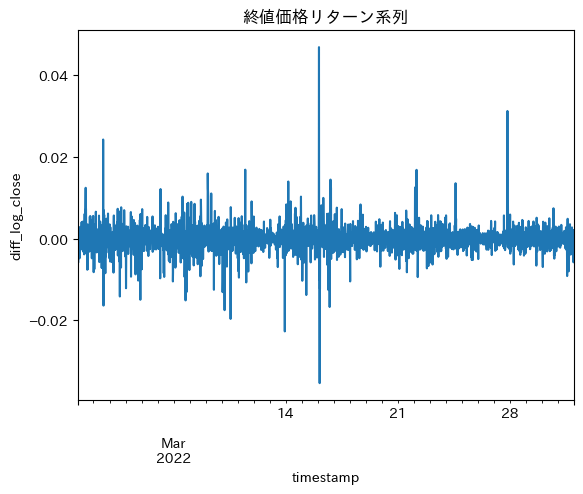

In [ ]:
# 終値価格リターン系列を確認
plt.title("終値価格リターン系列")
plt.ylabel("diff_log_close")
df["diff_log_close"].plot()

In [ ]:
# 関数の用意

# 可視化のための関数
def plot_result(target, pred, title, ylabel):
    plt.figure(figsize=(15,5))
    plt.plot(target.index, target, c='blue', label='実際', marker='.')
    plt.plot(target.index, pred, c='r', label='予測値', marker='.')
    plt.ylabel(ylabel, fontsize=17)
    plt.legend()
    plt.title(title)
    plt.show()

# 残差の可視化のための関数
def plot_resid(target, pred, title, ylabel):
    plt.figure(figsize=(15,5))
    plt.plot(target.index, target-pred, c='green', marker='.')
    plt.ylabel(ylabel, fontsize=17)
    plt.title(title)
    plt.show()

# train validationの分割のための関数
def timeseries_train_val_split(Xy, target="y"):
    # 時系列の前半75%を学習, 後半25%を検証に利用する
    train, val = Xy[:int(len(Xy)*0.75)], Xy[int(len(Xy)*0.75)+10:]
    trainX = train.drop([target],axis=1)
    trainy = train[target]
    valX = val.drop([target],axis=1)
    valy = val[target]
    return trainX, trainy, valX, valy

from sklearn.metrics import accuracy_score
# 上昇もしくは下落の予測のaccuracyを測定する関数
def eval_direction(target, pred):
    target = np.where(np.array(target) > 0, 1, -1)
    pred = np.where(np.array(pred) > 0, 1, -1)
    print("accuracy", accuracy_score(target, pred))

## 2.4.1 統計モデル

線形回帰モデルではデータが独立同分布に従うことが仮定されていますが, 一般に時系列データはそのようにはなっていません.<br>
時系列データの場合, ある時刻`t`のデータと`t+1`のデータには何らかの関係性が存在するはずだからです.(そのような関係性がない場合は予測ということ自体が不可能ということになるはずです.)<br>
ここでは「定常性」を満たすように前処理を実施した上で, 最も基本的な時系列データでの回帰モデルである`AR(1)`モデルを作成してみます.


- ARモデル(自己回帰モデル)

予測対象となる変数を$y_t$とすると, AR(1)モデルは以下のように書くことができます.<br>
$a_0$, $a_1$は係数, $ϵ_t$は時刻$t$における回帰の誤差項です.<br>
$$
y_{t+1} = a_0 + a_1 \times y_t + \epsilon_t
$$

式からもわかるとおり$a_0$, $a_1$の値がわかれば時刻$t$のデータ$y_t$から時刻${t+1}$の$y_{t+1}$を推定できるというものです.<br>
AR(1)と呼ばれる理由としては過去の値を1つのみ($y_{t+1}$の予測に$y_t$の値のみ)を利用しているためであり, 例えば$y_{t-1}$の値を使う場合は`AR(2)`となります.<br>
誤差項については線形回帰であることから平均0, 一定の分散値を取ることを仮定しており, さらに各時刻$t$に対して独立な関係であるということを仮定します.

- 定常性と検定の方法

定常性とは直感的には時間の変化に対してデータが安定的に推移するということを指します.<br>
時間の変化に対してデータ分布も大きく変動する場合にはある期間で学習したモデルは別の期間では使えないというような問題が発生してしまいます.<br>
データ$y_t$が定常性を持つことを数式で表すと以下のようになります.(定常性には強定常性, 弱定常性がありますがここでは弱定常性を取り扱います.)<br>
期待値をE, 共分散をCovと表しています.
$$ E(y_t) = μ $$
$$ Cov(y_t, y_{t-j}) = E[(y_t- μ)(y_{t-j}-μ)] = γ_j $$
これは時刻$t$によらず,データの期待値が一定であり, ラグjに対する自身との共分散が一定であるということを意味します.<br>

データが定常性を持つかどうかの検定について、AR(1)モデルを例として確認します.<br>
AR(1)モデルの場合に定常性の条件を当てはめてみます.<br>
$$E(y_{t+1}) = E(y_t) = μ$$であることから,
$$μ = a_0 + a_1 μ $$
$$a_0 = (1-a_1) μ $$
と係数$a_0$を期待値$\mu$を用いて表すことができます.こちらをAR(1)モデルに代入し両辺から$\mu$を引いた上で変換すると,
$$
y_{t+1} - \mu = (1-a_1) \mu +a_1 y_t + ϵ_t - \mu = a_1(y_t - \mu) + ϵ_t
$$
と表されます.tの値を再帰的に減らすことを繰り返し一般的な形で表すと,
$$
y_{t+1} - \mu = \sum_{i=0}^{∞} a_1^{i} ϵ_{t-i}
$$
と変形できます.<br>
ここで各時刻の誤差項$ϵ_t$は独立であることから,
$$
E[(y_t-\mu) ϵ_t] = 0
$$
という結果が得られ, この式は$y_t$と$ϵ_t$の共分散が0であることを表します.<br>
つまり,AR(1)モデルに対して時系列データ$y_t$を当てはめた結果の誤差項$\epsilon_t$と元データ$y_t$は独立であるということが言えます.<br/>
このことを用いて,同様にAR(1)モデルで分散について考えると,
$$
Var(y_{t+1}) = Var(a_0 + a_1y_t + ϵ_t) = a_1^2Var(y_t) + Var(ϵ_t)
$$
であり($ϵ_t$と$y_t$が独立であるため上記の変換が可能です.), 定常性の条件から各時刻$t$での$y_t$の分散の値は一定(定常性の定義２つ目から導くことができます.)であることから
$$
Var(y_t) = \frac{Var(ϵ_t)}{1-a_1^2}
$$
を導くことができます.<br>
分散の値は常に0以上であることから$a_1$の値が$-1<a_1<1$の範囲にある, ということが`AR(1)`モデルにおける定常性の必要十分条件であるということが導けました.

- ADF検定

上記で確認したように, ARモデルを正しく利用するためにはデータ$y_t$が定常である必要があります.<br>
$y_t$が定常であるかどうかを確認する方法としてADF検定と呼ばれる方法を紹介します.<br>
まず, ADF検定の前にDF検定ではAR(1)モデルのように
$$
Δy = y_{t+1} - y_t = (\phi - 1) y_t + ϵ_t
$$
という回帰式をとり, $\phi$の値が1であるかどうかを検定するというような方法で行います.<br>
先ほど確認した通り, 定常性の必要十分条件としてはAR(1)モデルのラグ１の変数の係数が-1より大きく1未満の範囲にあることでした.<br>
ADF検定はこのDF検定のラグをより拡張したものとなっています.<br>
この検定を実施するためにライブラリを導入し, タイムバーのデータに対して検定を実施します.

In [ ]:
# ADF検定用パッケージ
from statsmodels.tsa.stattools import adfuller

In [ ]:
def adf_test(data, sig_level = 0.05, do_print=True) -> bool:
    """
    ADF検定を実施する関数
    Args:
        data: 検定対象の系列データ
        sig_level: 有意水準
        do_print: 検定結果をprintするかどうか
    Returns:
        bool: Trueの場合定常,Falseの場合非定常を表す
    """
    if do_print:
        print('Results of Dickey-Fuller Examination:')
    dftest = adfuller(data)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    if do_print:
        print(dfoutput)
    return dfoutput['p-value'] < sig_level

- タイムバーでの定常性の確認

対数で変換したタイムバーの終値の価格系列`log_close`について定常性を確認します.

Results of Dickey-Fuller Examination:
Test Statistic                   -1.056981
p-value                           0.731919
#Lags Used                        4.000000
Number of Observations Used    2970.000000
dtype: float64
対数価格系列は非定常である


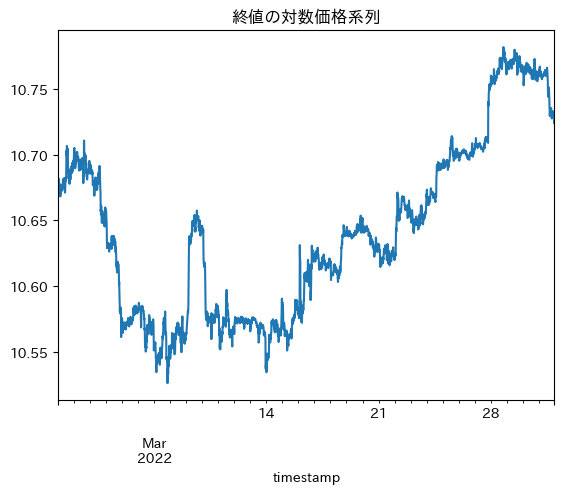

In [ ]:
plt.title("終値の対数価格系列")
df["log_close"].plot()

if adf_test(df["log_close"], do_print=True):
    print("対数価格系列は定常である")
else:
    print("対数価格系列は非定常である")

- 差分を取ったタイムバーでの定常性の確認

対数変換した終値の価格系列に対して差分を取った`diff_log_close`の列について定常性を確認します.

Results of Dickey-Fuller Examination:
Test Statistic                  -27.754658
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    2971.000000
dtype: float64
1次差分系列は定常である


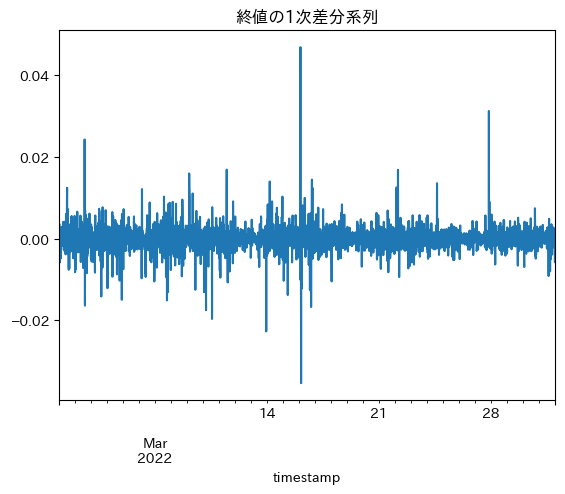

In [ ]:
# 対数価格系列に対する1階の次差分
plt.title("終値の1次差分系列")
df["diff_log_close"].plot()

if adf_test(df["diff_log_close"], do_print=True):
    print("1次差分系列は定常である")
else:
    print("1次差分系列は非定常である")

- AR(1)モデルを用いた分析

ここからは実際にAR(1)モデルを用いて分析を実施します.<br>
定常化した`diff_log_close`列についてAR(1)モデルを当てはめ誤差項を確認します.<br>
AR(1)モデルでは以下の図のようなイメージで`diff_log_close`の予測を実施します.

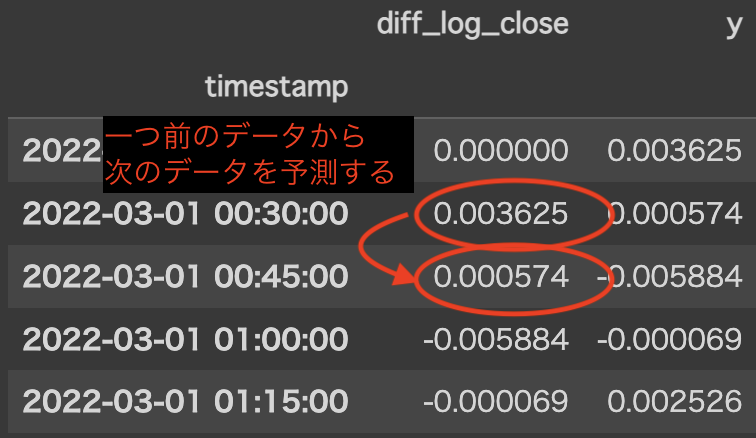

In [ ]:
# 回帰モデルの導入
from sklearn.linear_model import LinearRegression

In [ ]:
# データと予測対象になるラベルの用意
Xy = df[["diff_log_close"]]
# 予測対象として,diff_log_closeの1ステップ先の値を設定しています.
Xy["y"] = df["diff_log_close"].shift(-1)
Xy.dropna(inplace=True)
Xy.head()

diff_log_close         y
timestamp                                    
2022-03-01 00:15:00        0.000000  0.003625
2022-03-01 00:30:00        0.003625  0.000574
2022-03-01 00:45:00        0.000574 -0.005884
2022-03-01 01:00:00       -0.005884 -0.000069
2022-03-01 01:15:00       -0.000069  0.002526

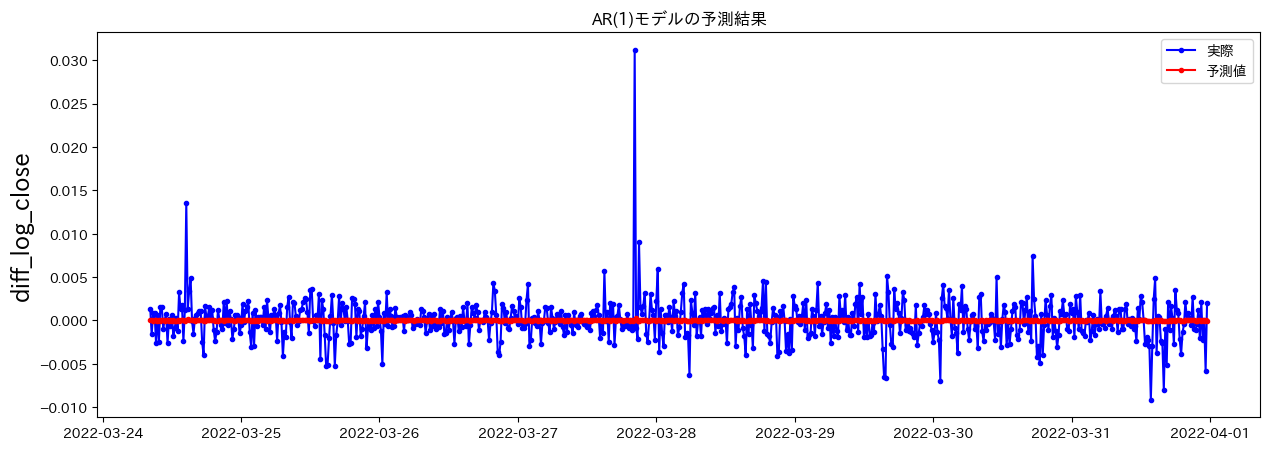

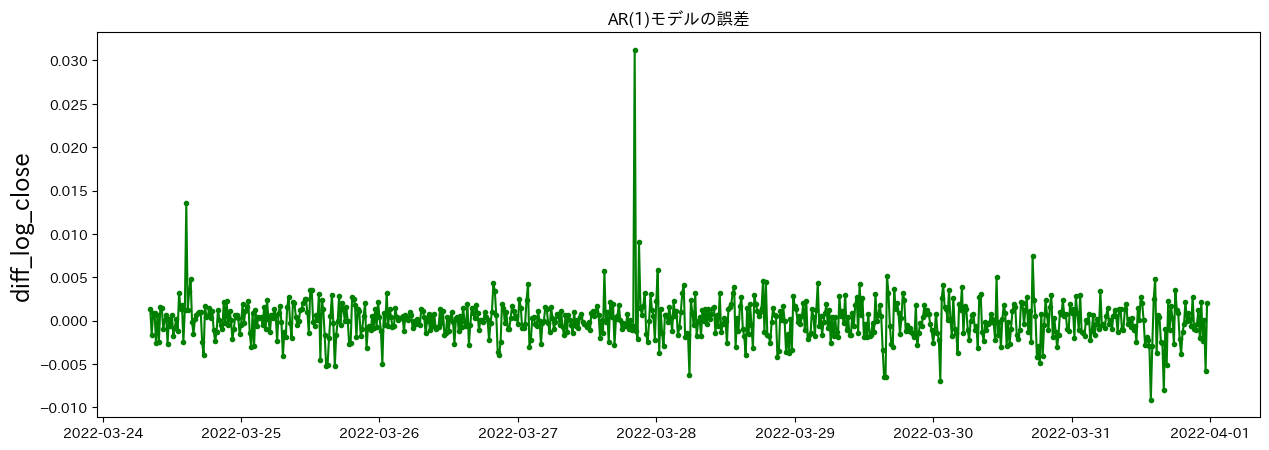

In [ ]:
# trainとvalidationの分割
trainX, trainy, valX, valy = timeseries_train_val_split(Xy, target="y")

# AR(1)モデルの設定とfitting
lr = LinearRegression()
lr.fit(trainX[["diff_log_close"]], trainy)
pred = lr.predict(valX[["diff_log_close"]])

# 結果のプロット
plot_result(target=valy, pred=pred, title="AR(1)モデルの予測結果", ylabel="diff_log_close")
plot_resid(valy, pred, title="AR(1)モデルの誤差", ylabel="diff_log_close")

予測値は実際の値よりもかなり小さな範囲に分布していることが確認できます.

In [ ]:
# 評価
eval_direction(valy, pred)

accuracy 0.49591280653950953


- 利点と欠点

ARモデルのような一般に統計モデルを作成した場合の利点と欠点は以下の通りです.

  - 利点
    - 計算が高速.
    - 大量のデータは必要ない
    - 解釈が容易
  - 欠点
    - 入力に対してデータが線形に応答しない場合の特徴を捉えられない
    - パラメータ選択,モデル選択などでテクニックが必要

## 2.4.2 機械学習モデル

一般に使われるようなrandam forestのような機械学習モデルはテーブル形式のデータに対して利用することを想定しており, 金融データのような時系列のデータを分析することを目的として開発されていません.<br>
そのため, このような機械学習モデルを利用するためには時系列データを適切に処理して利用する必要があります.<br>
本節ではサンプルとして対数を取った後に差分処理をした値を特徴量として利用します.<br>
以下の図のようなイメージで, 各行を独立な1データとして一般のテーブルデータの予測と同様に扱います.<br>
従って,各行は前後の行との相関をできるだけ持たないよう定常化する処理などが必要になります.

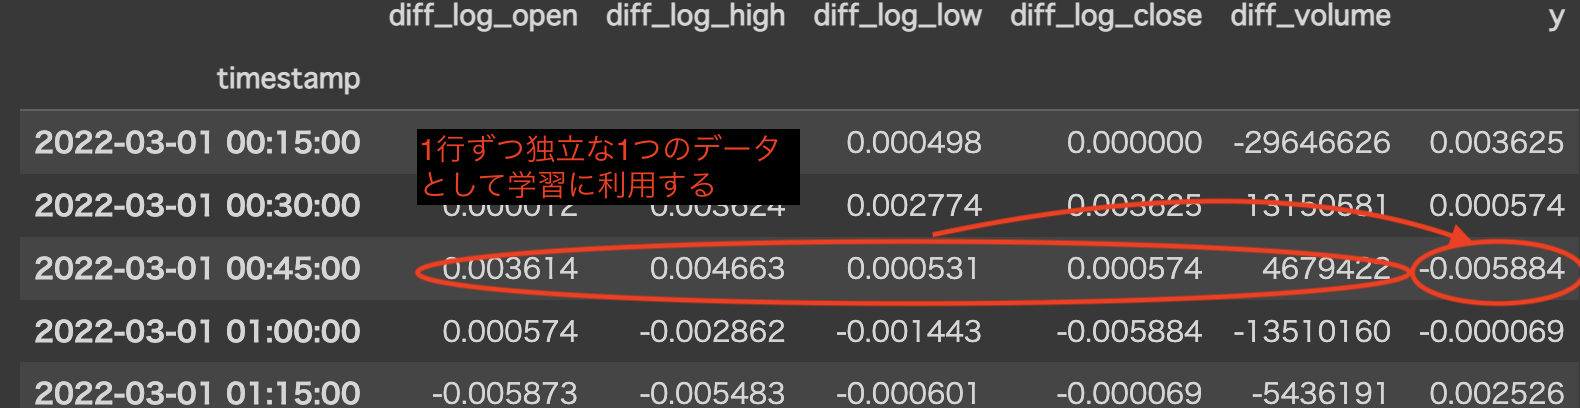

In [ ]:
# データとラベルの用意
Xy = df[["diff_log_open", "diff_log_high", "diff_log_low", "diff_log_close", "diff_volume"]]
Xy["y"] = df["diff_log_close"].shift(-1)
Xy.dropna(inplace=True)
Xy.head()

diff_log_open  diff_log_high  diff_log_low  \
timestamp                                                         
2022-03-01 00:15:00       0.004333      -0.004806      0.000498   
2022-03-01 00:30:00       0.000012       0.003624      0.002774   
2022-03-01 00:45:00       0.003614       0.004663      0.000531   
2022-03-01 01:00:00       0.000574      -0.002862     -0.001443   
2022-03-01 01:15:00      -0.005873      -0.005483     -0.000601   

                     diff_log_close diff_volume         y  
timestamp                                                  
2022-03-01 00:15:00        0.000000   -29646626  0.003625  
2022-03-01 00:30:00        0.003625    13150581  0.000574  
2022-03-01 00:45:00        0.000574     4679422 -0.005884  
2022-03-01 01:00:00       -0.005884   -13510160 -0.000069  
2022-03-01 01:15:00       -0.000069    -5436191  0.002526

In [ ]:
# random forestモデルの用意
from sklearn.ensemble import RandomForestRegressor

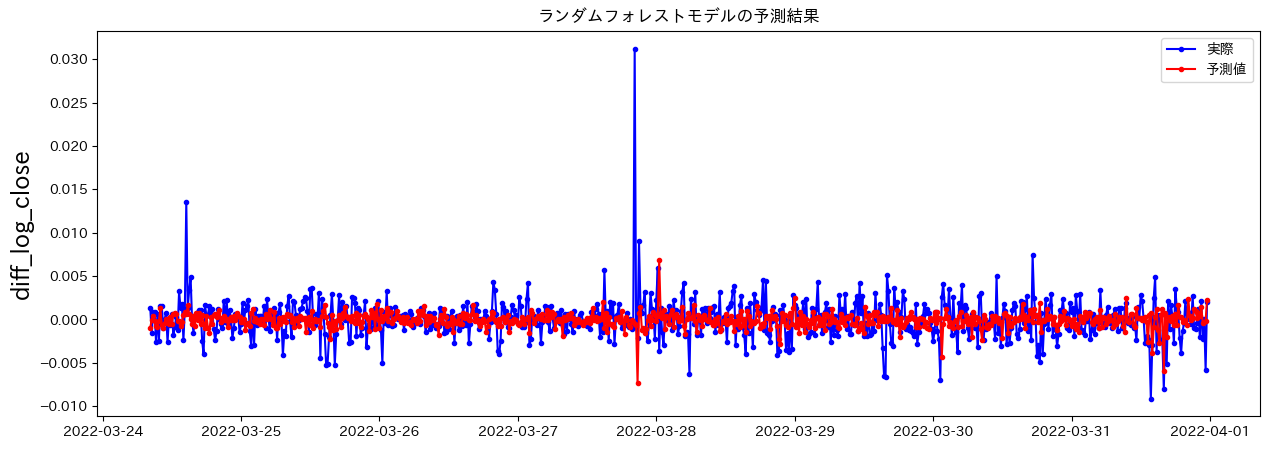

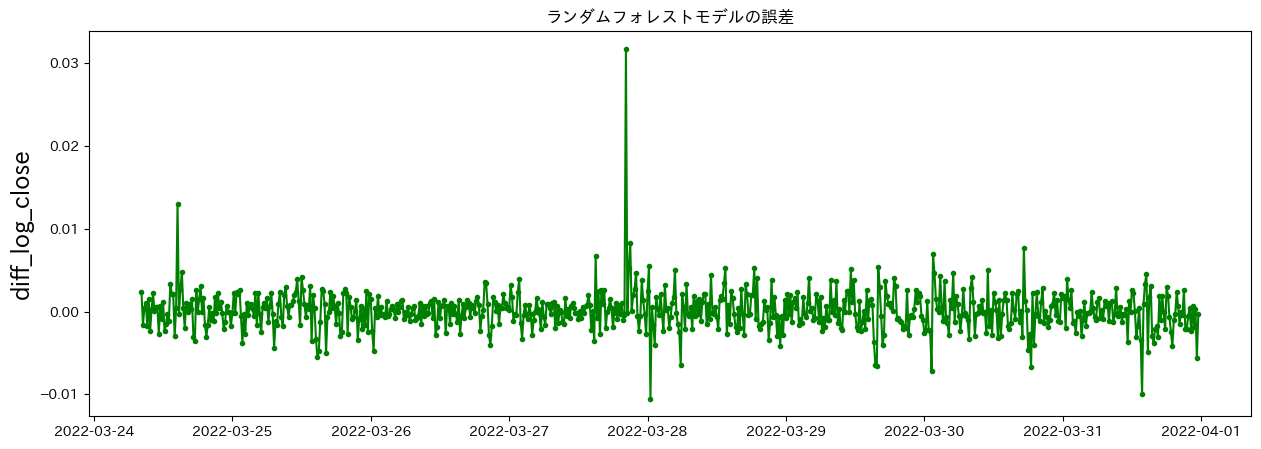

In [ ]:
# trainとvalidationを分割
trainX, trainy, valX, valy = timeseries_train_val_split(Xy, target="y")

# モデルの定義とfitting
rf = RandomForestRegressor(random_state=0)
rf.fit(trainX,trainy)
pred = rf.predict(valX)

# 可視化
plot_result(target=valy, pred=pred, title="ランダムフォレストモデルの予測結果", ylabel="diff_log_close")
plot_resid(valy, pred, title="ランダムフォレストモデルの誤差", ylabel="diff_log_close")

In [ ]:
# 評価
eval_direction(valy, pred)

accuracy 0.4904632152588556


今回のrandom forestの価格変動の予測結果はARモデルとあまり変わらないものでした.<br>
これは特徴量としてohlcvの値のみを利用していたことが原因に考えられます.<br>
2.5節ではここにさらにテクニカル指標と呼ばれる特徴量を追加して同様の時系列予測を試します.

- 利点と欠点

- 利点
 - 非線形な特徴を捉えることが可能
 - 様々な特徴量を利用することが可能

- 欠点
 - 特徴量を適切に前処理する必要がある
 - 必ずしも統計モデルより精度が高くなるという保証はない

## 2.4.3 ディープラーニング

最後にディープラーニングを用いた`diff_log_close`の予測を実施します.<br>
ディープラーニングを用いる場合はrandom forestのように必ずしも定常化する処理が必要というわけではありません.<br>
一方で学習を安定させるために今回は標準化(平均0,分散1になるような処理)を実施します.<br>
注意点として, 標準化の処理のために未来の情報を用いて前処理を実施するのは不適切です.従ってタイムバーのデータ全体を参照して平均値と分散を計算し, 標準化を実施することはできません.<br>
そこで今回は直前10本分のデータの平均と分散を用いた標準化による前処理を実施し, 入力変数として利用します.<br>
2.4.3節では時系列データに対するディープラーニングモデルとして有名な`LSTM`を用いて価格変動の予測を行います.<br>
LSTMにおける利用データと予測値のイメージは以下のようになります.<br>
時間方向にL個, 特徴量をN個とした(LxN)のテンソルを入力とし未来の価格変動`diff_log_close`を予測します.

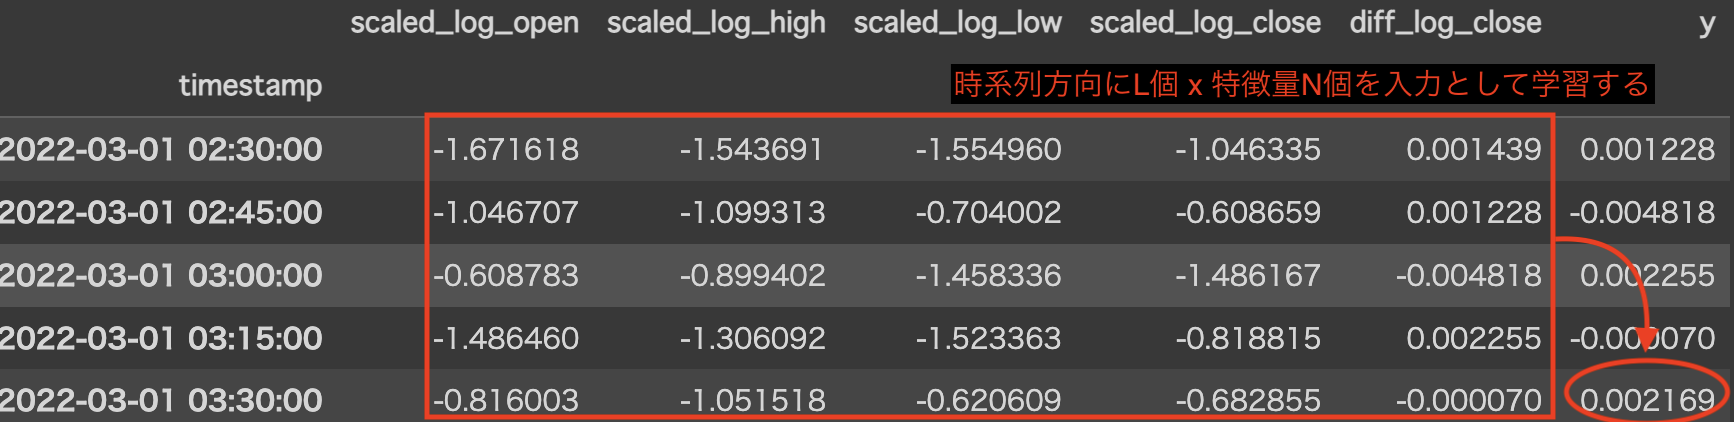

- LSTMの構造

詳細については割愛しますが, イメージとしては下図のように系列データ{$x_t$}が$x_{t-1}$, $x_t$... と順次LSTM層に入力され, 隠れ層$h_t$が各ステップにおいて出力されます.

参考: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

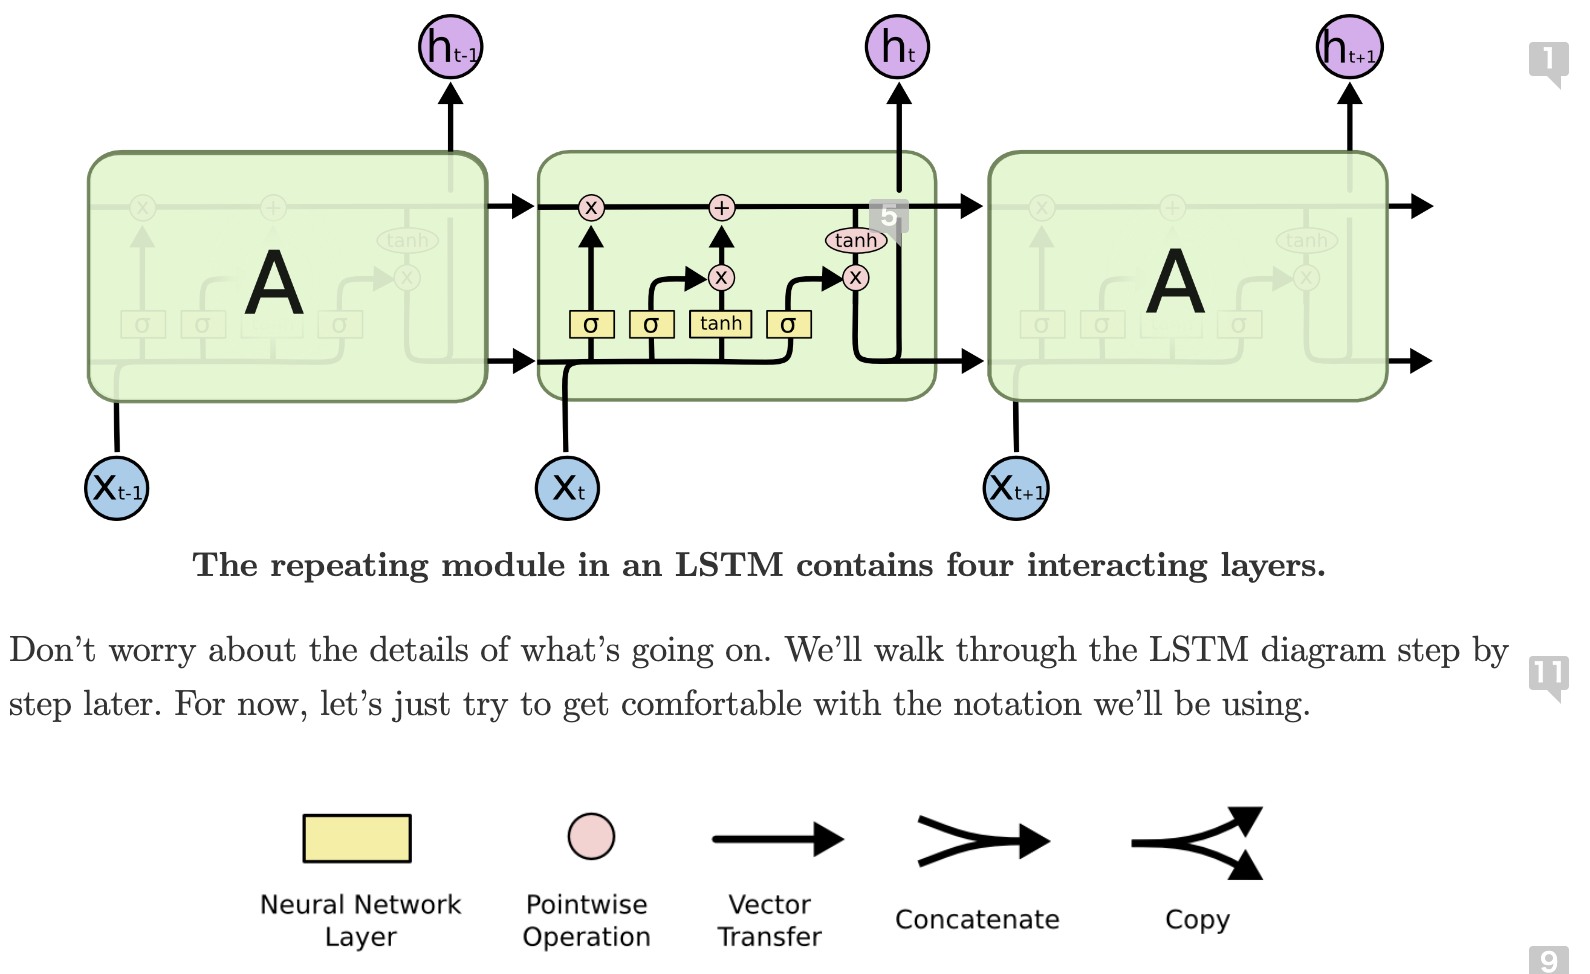

In [ ]:
# データとラベルの用意

# 過去10本分の平均と標準偏差を用いて標準化を実施(未来情報を参照しないように標準化)
df["scaled_log_open"] = (df["log_open"] - df["log_open"].rolling(10).mean()) / df["log_open"].rolling(10).std()
df["scaled_log_high"] = (df["log_high"] - df["log_high"].rolling(10).mean()) / df["log_high"].rolling(10).std()
df["scaled_log_low"] = (df["log_low"] - df["log_low"].rolling(10).mean()) / df["log_low"].rolling(10).std()
df["scaled_log_close"] = (df["log_close"] - df["log_close"].rolling(10).mean()) / df["log_close"].rolling(10).std()

Xy = df[["scaled_log_open", "scaled_log_high", "scaled_log_low", "scaled_log_close", "diff_log_close"]]
Xy["y"] = df["diff_log_close"].shift(-1)
Xy.dropna(inplace=True)
Xy.head()

scaled_log_open  scaled_log_high  scaled_log_low  \
timestamp                                                               
2022-03-01 02:30:00        -1.671618        -1.543691       -1.554960   
2022-03-01 02:45:00        -1.046707        -1.099313       -0.704002   
2022-03-01 03:00:00        -0.608783        -0.899402       -1.458336   
2022-03-01 03:15:00        -1.486460        -1.306092       -1.523363   
2022-03-01 03:30:00        -0.816003        -1.051518       -0.620609   

                     scaled_log_close  diff_log_close         y  
timestamp                                                        
2022-03-01 02:30:00         -1.046335        0.001439  0.001228  
2022-03-01 02:45:00         -0.608659        0.001228 -0.004818  
2022-03-01 03:00:00         -1.486167       -0.004818  0.002255  
2022-03-01 03:15:00         -0.818815        0.002255 -0.000070  
2022-03-01 03:30:00         -0.682855       -0.000070  0.002169

<Axes: title={'center': '標準化した対数終値系列'}, xlabel='timestamp', ylabel='scaled_log_close'>

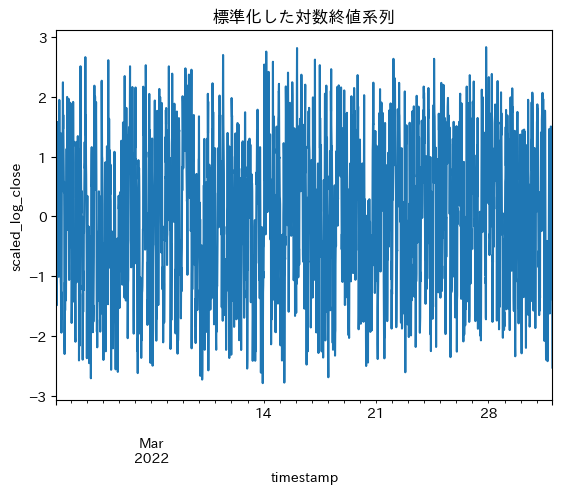

In [ ]:
# 標準化の結果確認
plt.title("標準化した対数終値系列")
plt.ylabel("scaled_log_close")
Xy["scaled_log_close"].plot()

標準化によりデータが一定範囲に分布していることが確認できます.

- LSTMの学習の用意

In [ ]:
from torch import nn
# LSTMを用いた回帰モデルの定義
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, batch_first):
        super(LSTMRegressor, self).__init__()
        # lstm層の設定
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, batch_first=batch_first
        )
        # 出力層の設定
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        h, _ = self.lstm(inputs)
        # LSTM層から出力される隠れ層を出力層に通して予測結果を得る
        output = self.output_layer(h[:, -1])
        return output

In [ ]:
import torch
from torch.utils.data import Dataset

# LSTMを学習するためのデータセット
class TimeBarDataset(Dataset):
    def __init__(self, df, features, target, sequence_length):
        self.df = df
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.index = df.index

    def __len__(self):
        return len(self.index) - self.sequence_length + 1

    def __getitem__(self, idx):
        # startからendの期間の長さ(self.sequence_length)の分の長さを入力として利用します.
        start = self.index[idx]
        end = self.index[idx + self.sequence_length-1]
        # X.shape = (self.sequence_length(入力時系列の長さ) x input_size(特徴量の個数)) のテンソル
        # y.shape = (output_size) のテンソル
        return torch.from_numpy(self.df[start: end][self.features].values).float(), torch.from_numpy(self.df[end:end][self.target].values).float()

In [ ]:
import torch.optim as optim

# Trainerの設定
class Trainer:
    def __init__(self, model, epochs, lr):
        self.sequence_length = sequence_length
        # model
        self.model = model
        self.best_model = self.model
        # train pram
        self.lr = lr
        self.epochs = epochs
        self.device = torch.device("cpu") # 演習ではcpuを利用します.

        # loss functionの設定
        self.criterion = nn.MSELoss(reduction="mean")
        # optimizerの設定
        self.optimizer = optim.Adam(
            self.model.parameters(), lr=lr, betas=(0.9, 0.999), amsgrad=True
        )

    def train(self, train_dataloader, val_dataloader):
        """学習の実施
        """
        best_loss = float("inf")
        for epoch in range(self.epochs):
            print("-------------")
            print("Epoch {}/{}".format(epoch + 1, self.epochs))
            print("-------------")
            train_loss = 0.0
            test_loss = 0.0
            self.model.train()
            for (X,y) in train_dataloader:
                out = self.model(X)
                loss = self.criterion(out, y)
                self.optimizer.zero_grad()
                loss.backward()
                # 学習の安定のために勾配のクリップを設定
                nn.utils.clip_grad_value_(self.model.parameters(), clip_value=2.0)
                self.optimizer.step()
                train_loss += loss.item()

            self.model.eval()
            with torch.no_grad():
                for batch in val_dataloader:
                    out = self.model(X)
                    loss = self.criterion(out, y)
                    test_loss += loss.item()

            train_loss /= len(train_dataloader)
            test_loss /= len(val_dataloader)
            # テスト誤差が最小のものをbest_modelとする
            if test_loss < best_loss:
                best_loss = test_loss
                self.best_model = self.model
                print("save best model!!")
            print("loss: {:.3}, test_loss: {:.3}".format(train_loss, test_loss))

    def predict(self, val_dataset):
        """予測
        """
        res = []
        self.best_model.eval()
        with torch.no_grad():
            for (X, y) in val_dataset:
                out = self.best_model(X.unsqueeze(0))
                res.append(out.item())
        return res

In [ ]:
from torch.utils.data import DataLoader

# trainとvalidationを分割
train, val = Xy[:int(len(Xy)*0.7)], Xy[int(len(Xy)*0.7)+10:]
# seedの固定
np.random.seed(0)
torch.manual_seed(0)

# 各種パラメータの設定
# 入力長の設定
sequence_length = 10
# モデルのパラメータ設定
input_size = 4
output_size = 1
hidden_size = 32
batch_first = True
# その他パラメータの設定
epochs = 10
lr = 0.01

# datasetの用意
train_dataset = TimeBarDataset(train, ["scaled_log_open", "scaled_log_high", "scaled_log_low", "scaled_log_close"], "y", sequence_length)
val_dataset = TimeBarDataset(val, ["scaled_log_open", "scaled_log_high", "scaled_log_low", "scaled_log_close"], "y", sequence_length)
print("train:", len(train_dataset), "val: ", len(val_dataset))

# 学習用Dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    drop_last=True,
    pin_memory=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    drop_last=True,
    pin_memory=True
)

model = LSTMRegressor(input_size,output_size,hidden_size,batch_first)

trainer = Trainer(model,epochs,lr)
trainer.train(train_dataloader, val_dataloader)

train: 2066 val:  871
-------------
Epoch 1/10
-------------
save best model!!
loss: 0.000425, test_loss: 7.79e-06
-------------
Epoch 2/10
-------------
loss: 1.83e-05, test_loss: 8.38e-06
-------------
Epoch 3/10
-------------
loss: 2.2e-05, test_loss: 1.2e-05
-------------
Epoch 4/10
-------------
loss: 2.2e-05, test_loss: 3.8e-05
-------------
Epoch 5/10
-------------
loss: 1.76e-05, test_loss: 1e-05
-------------
Epoch 6/10
-------------
loss: 1.96e-05, test_loss: 1.28e-05
-------------
Epoch 7/10
-------------
loss: 1.67e-05, test_loss: 1.4e-05
-------------
Epoch 8/10
-------------
loss: 1.47e-05, test_loss: 9.53e-05
-------------
Epoch 9/10
-------------
loss: 1.68e-05, test_loss: 1.46e-05
-------------
Epoch 10/10
-------------
loss: 1.95e-05, test_loss: 1.11e-05


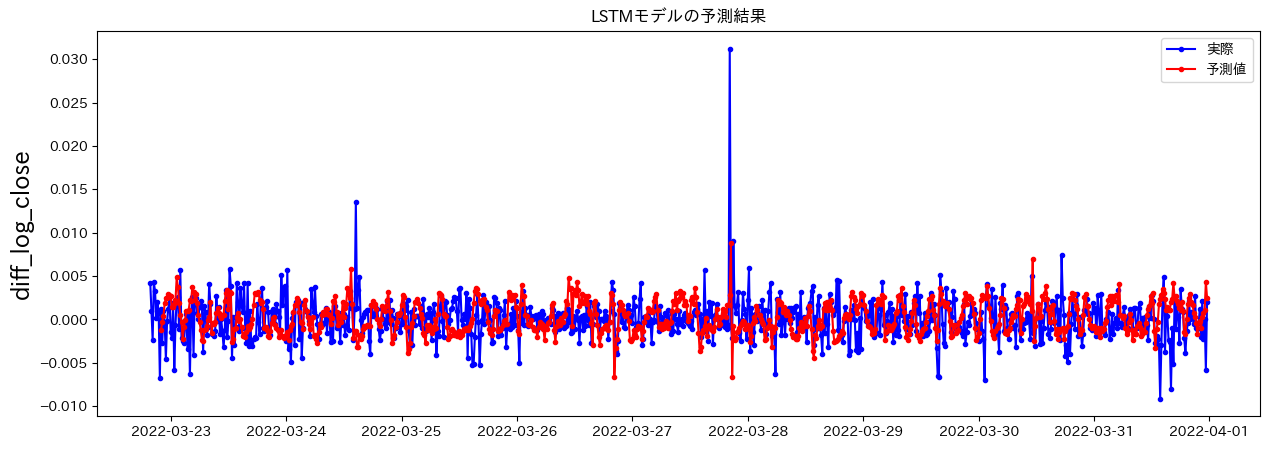

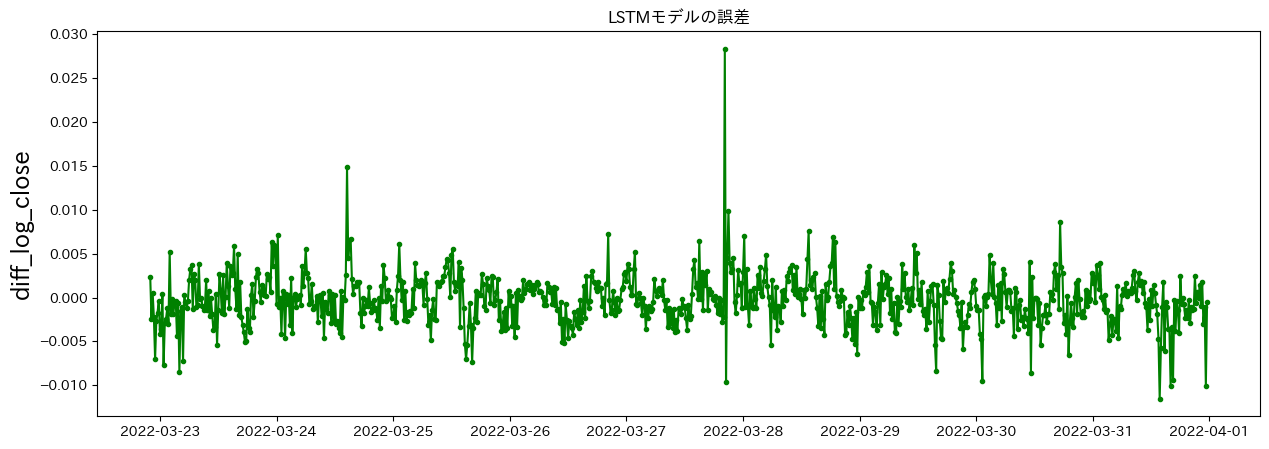

In [ ]:
# val_datasetを用いて予測
pred = trainer.predict(val_dataset)

# LSTMの都合上初めのsequence_length-1の長さ分はNoneで埋める
pred = [None]*(sequence_length-1) + pred

# 可視化
plot_result(target=val["y"], pred=pred, title="LSTMモデルの予測結果", ylabel="diff_log_close")
plot_resid(val["y"][sequence_length-1:], pred[sequence_length-1:], title="LSTMモデルの誤差", ylabel="diff_log_close")

In [ ]:
# 評価
eval_direction(val["y"][sequence_length-1:], pred[sequence_length-1:])

accuracy 0.5223880597014925


今回のLSTMによる価格の変動の予測の結果はrandom forestやARモデルを上回る結果を得ることができました.

- 利点と欠点
- 利点
  - 時系列に特化したアーキテクチャのモデルを利用可能
  - 柔軟にデータの特徴を学習できる
  - 定常性の要件が必ずしも必要というわけではない

- 欠点
 - 多くのデータが必要
 - 計算リソースが必要
 - 適切な前処理やパラメータチューニングが必要

# 2.5 機械学習を用いた金融データ分析のための前処理

ゴール:特徴量生成の目的および方法, 注意点を学ぶ. テクニカル指標について学ぶ. 定常性の概念の理解および定常化のための処理を身につける.

2.4節では対数処理, 差分処理をしたohlcvのタイムバー系列を用いて次のステップの価格の変動の予測を実施しました.<br>
一方で実際のトレーダーや投資家はohlcvのテーブルだけをみて取引をしているということはあまりありません.テクニカル指標と呼ばれる金融データ特有の指標を参考にして取引を行うことがあります.<br>
2.5節ではこれらテクニカル指標を機械学習の将来予測をするための特徴量として利用する方法を学びます.<br>
テクニカル指標を追加する操作は以下の図のようなイメージです.

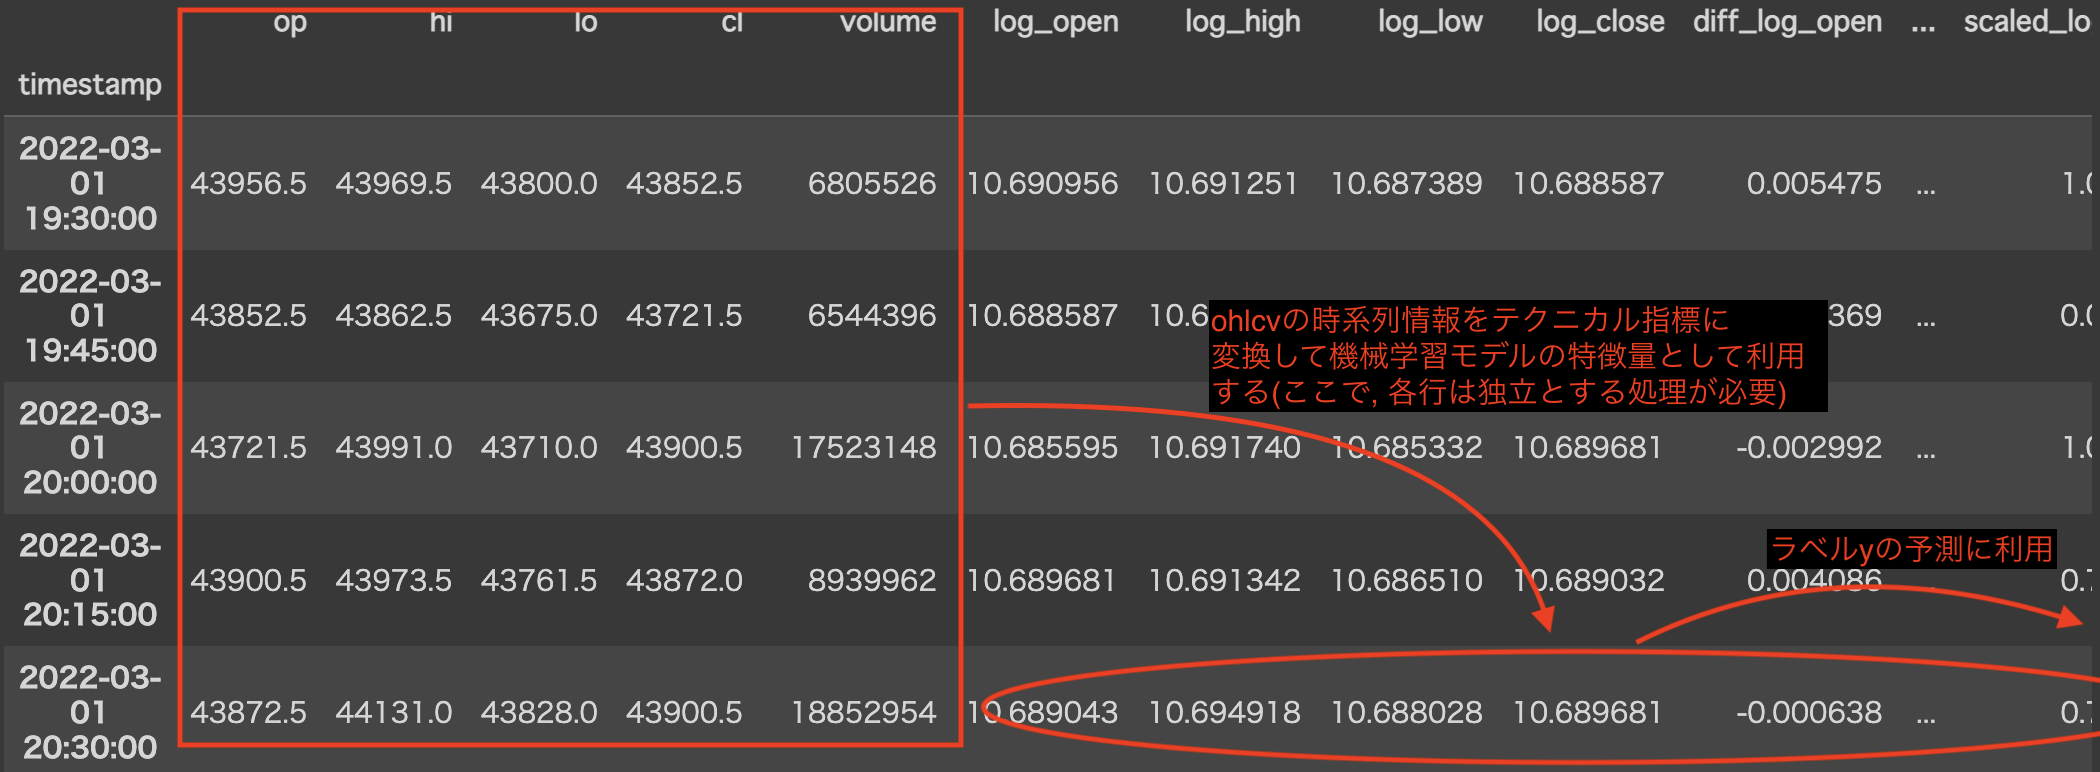

## 2.5.1 注意点

金融時系列データを処理して特徴量を作成し機械学習に利用する際には以下の項目に注意する必要があります.

- 先読み

分析時には未来の情報も参照することが可能な状態です.(先読みと呼びます.)しかし, 実際に運用を行う際には当然未来の情報を参照することはできません.<br>
特徴量の生成において未来の情報を含むようなものを誤って利用しないように注意が必要です.

- 無限の過去を参照するような特徴量

実際の運用時には無限の長さの過去を参照して特徴量を生成することはできません.<br>
従って, 累積和を取るような特徴量など入力するタイムバーの長さに応じて生成される値が変動するような特徴量を利用すると実運用時に期待した値とは異なるものとなってしまうため注意が必要です.<br>
運用時には500本のタイムバーから特徴量を作成する想定です.
(例)累積和を取る指標など

- 定常性

2.4節でも確認した通り, データが定常になるように処理をすることが好ましいです.<br>
ただし, 統計的に完全に定常性を持たせるということは難しいことが多く許容できるような形に落とし込むという対応が取られます.

- 計算速度

こちらはどのような戦略を取るかにもよりますが, あまりにも計算に時間がかかるような特徴量を生成するのは好ましくありません.<br>
計算をしている間に実際に発注したいタイミングを逃してしまうなど, バックテスト時にはない問題などを招く可能性があるためです.

## 2.5.2 各種テクニカル指標

ゴール： 各種テクニカル指標の扱いを理解する. 金融機械学習に利用できるデータを生成できるようになる.

テクニカル指標とは価格や出来高の推移をもとに算出する指標であり多くの種類が存在します.

テクニカル指標を算出するためのライブラリとして主に以下のようなものが存在します.

- [Talib](https://mrjbq7.github.io/ta-lib/)
- [ta](https://github.com/bukosabino/ta)
- [pandas-ta](https://github.com/twopirllc/pandas-ta)

本講義ではcolabratory上での準備が容易なpandas-taを利用します.

In [ ]:
# pandas-taのインストール
!pip install pandas-ta

テクニカル指標について

テクニカル指標の代表的なものを列挙すると以下のようなものが存在します.

+ トレンド系指標<br>
相場の方向性に沿った形で売買を行うもの.いわゆる『順張り』の投資スタンスを持つものです.<br>
例:移動平均線, 一目均衡表, パラボリック・タイム・プライス, ポイント＆フィギュア

+ オシレータ系指標<br>
相場の方向とは逆に売買を行う.つまり上げ過ぎているから売り, 下げ過ぎているから買いといったいわゆる『逆張り』の投資スタンスを持つものです.<br>
例:ＲＳＩ, ストキャスティクス, ボリンジャーバンド（標準偏差）, 移動平均乖離率,ＭＡＣD

+ サイクル分析<br>
過去の価格変動を遡って分析し一定のパターンを見つけることによって将来の価格変動を予測することを目的としたものです.<br>
例:一目均衡表


※厳密な区分がある訳ではなく,同じ分析手法であっても使い方次第で変わります.

また, テクニカル指標の種類によっては参照可能な範囲で無限に過去のデータを参照して計算するようなものもあります.このような指標の利用は好ましくないことは先に述べた通りですので, 実運用を見据えて過去の参照点を一定範囲までで打ち切るように工夫する等の処理を行うことが重要です.

In [ ]:
import pandas_ta as ta

### トレンド系指標

SMA(単純移動平均線)についてpandas-taを用いて算出と可視化を行います.SMA(単純移動平均線)についてpandas-taを用いて算出と可視化を行います.

SMAは以下のような式で算出され, lengthの期間の価格の平均値を計算するものです.

$$
SMA_t = (y_t + y_{t-1} + \dots y_{t-length+1}) / length
$$

Text(0, 0.5, 'SMA')

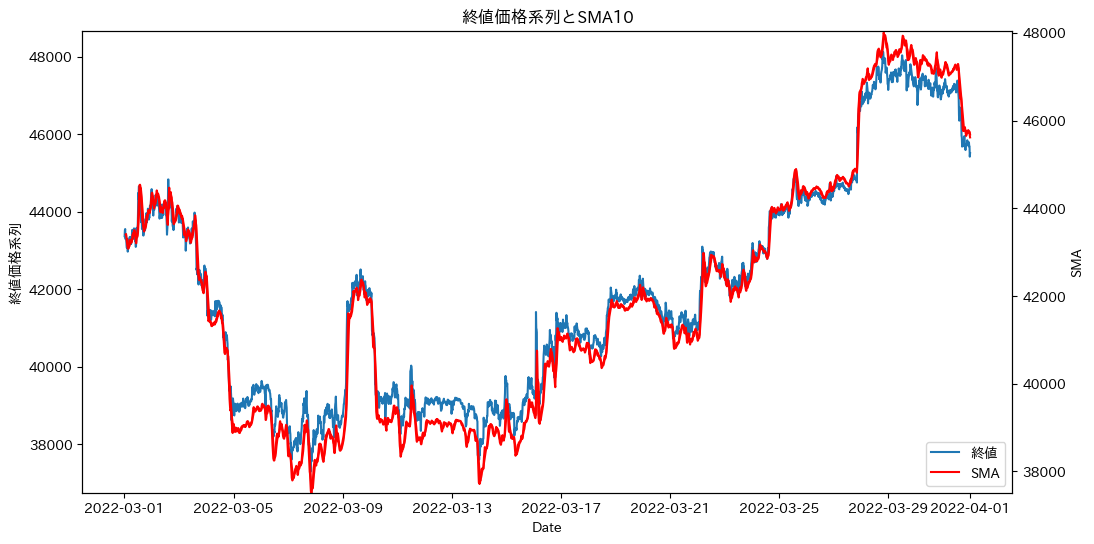

In [ ]:
# SMAを算出
df["sma5"] = ta.sma(df["cl"], length=5)
df["sma10"] = ta.sma(df["cl"], length=10)

plt.figure(figsize=(12,6))
plt.title("終値価格系列とSMA10")

#終値系列
plt.plot(df.index, df.cl, label="終値")
plt.legend(loc='lower right')
plt.ylabel("終値価格系列", fontsize=10)
plt.xlabel('Date')

#軸と凡例の設定
plt.plot([],[],color='r',label='SMA')
plt.legend(loc='lower right')
plt.twinx()

#sma
plt.plot(df["sma5"],color="r", label="SMA5")
plt.plot(df["sma10"],color="r", label="SMA10")
plt.ylim([min(df["sma10"].dropna())-100, max(df["sma10"].dropna())+100])
plt.ylabel("SMA", fontsize=10)

SMAでは平均値を取るので滑らかな動きになるということが確認できます.

### オシレーター系指標

ボリンジャーバンドについてpandas-taを用いて算出と可視化を行います.

ボリンジャーバンドは移動平均線とその上下2本ずつの標準偏差の値5本からなる線で表されるものです.

これは高い確率で$-2σ$から$2\sigma$の間で価格は推移するだろうという統計的な分析に基づく指標であり,この線を超えたときに発注を行う, などの利用が考えられます.

Text(0, 0.5, 'BBands')

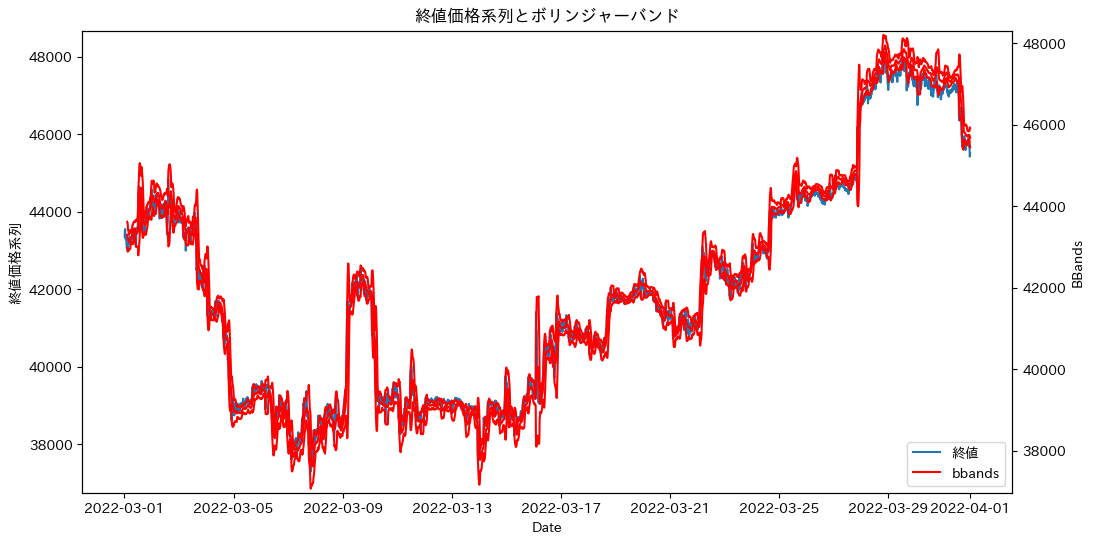

In [ ]:
bbands = ta.bbands(df["cl"], length=10)

df["BBL_10_2.0"] = bbands["BBL_10_2.0"] # 下の線
df["BBM_10_2.0"] = bbands["BBM_10_2.0"] # 移動平均線
df["BBU_10_2.0"] = bbands["BBU_10_2.0"] # 上の線

df["BBB_10_2.0"] = bbands["BBB_10_2.0"] # バンドの幅
df["BBP_10_2.0"] = bbands["BBP_10_2.0"] # (close - lower) / (upper-lower)

plt.figure(figsize=(12,6))
plt.title("終値価格系列とボリンジャーバンド")

#終値系列
plt.plot(df.index, df.cl, label="終値")
plt.legend(loc='lower right')
plt.ylabel("終値価格系列", fontsize=10)
plt.xlabel('Date')

#軸と凡例の設定
plt.plot([],[],color='r',label='bbands')
plt.legend(loc='lower right')
plt.twinx()

#bbands
plt.plot(df['BBL_10_2.0'],color="r", label="BBL")
plt.plot(df['BBM_10_2.0'],color="r", label="bbands")
plt.plot(df['BBU_10_2.0'],color="r", label="BBU")
plt.ylim([min(df["BBL_10_2.0"].dropna())-100, max(df["BBU_10_2.0"].dropna())+100])
plt.ylabel("BBands", fontsize=10)

### サイクル分析

最後に一目均衡表についてもpandas-taで確認します.

一目均衡表は市場の売り手と買い手のどちらが優勢かを見ることのできる指標とされており, 一方が優勢になると均衡が崩れるということからこのような名前がついています.

こちらは5本の線を生成します.

Text(0, 0.5, '一目均衡表')

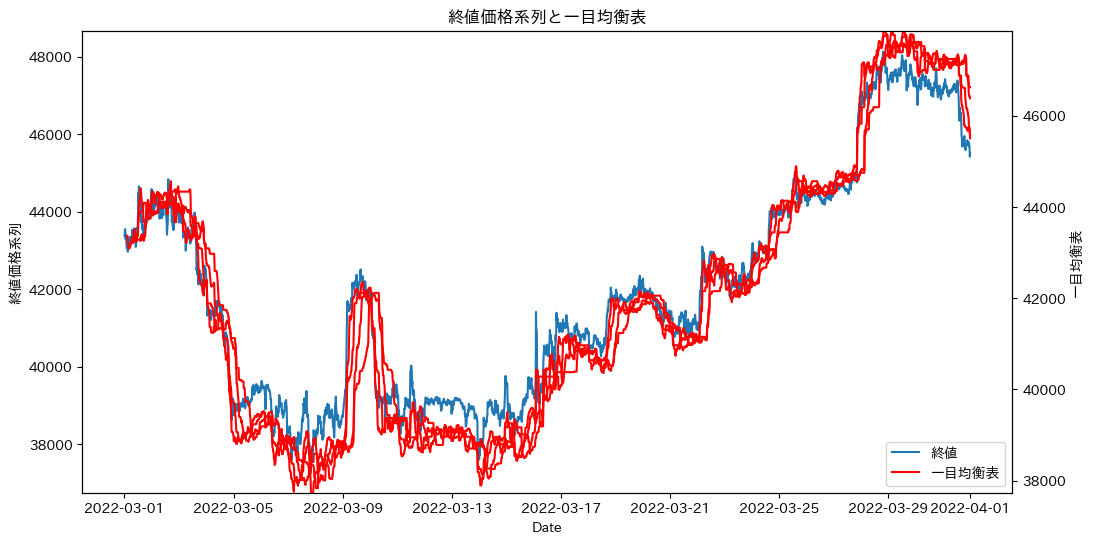

In [ ]:
ichimoku_visible, _ = ta.ichimoku(df["hi"], df["lo"], df["cl"])
df["ISA_9"] = ichimoku_visible["ISA_9"] # spanA
df["ISB_26"] = ichimoku_visible["ISB_26"] # spanB
df["ITS_9"] = ichimoku_visible["ITS_9"] # 転換線
df["IKS_26"] = ichimoku_visible["IKS_26"] # 基準線
# df["ICS_26"] = ichimoku_visible["ICS_26"] # 一目スパン(現在の値がNoneになるので利用しません)

plt.figure(figsize=(12,6))
plt.title("終値価格系列と一目均衡表")

#終値系列
plt.plot(df.index, df.cl, label="終値")
plt.legend(loc='lower right')
plt.ylabel("終値価格系列", fontsize=10)
plt.xlabel('Date')

#軸と凡例の設定
plt.plot([],[],color='r',label='一目均衡表')
plt.legend(loc='lower right')
plt.twinx()

#ichomoku
plt.plot(df["ISA_9"],color="r", label="ISA_9")
plt.plot(df["ISB_26"],color="r", label="ISB_26")
plt.plot(df["ITS_9"],color="r", label="ITS_9")
plt.plot(df["IKS_26"],color="r", label="IKS_26")
plt.ylim([min(df["IKS_26"].dropna())-100, max(df["IKS_26"].dropna())+100])
plt.ylabel("一目均衡表", fontsize=10)

今回紹介した以外にもテクニカル指標はさまざまなものが存在しています.

pandas-taの実装ライブラリやそのほか金融機関ウェブページ等参考にテクニカル指標の利用を検討しましょう.

In [ ]:
# テクニカル指標を追加したdfの確認
df.dropna(inplace=True)
df

op       hi       lo       cl    volume   log_open  \
timestamp                                                                      
2022-03-01 19:30:00  43956.5  43969.5  43800.0  43852.5   6805526  10.690956   
2022-03-01 19:45:00  43852.5  43862.5  43675.0  43721.5   6544396  10.688587   
2022-03-01 20:00:00  43721.5  43991.0  43710.0  43900.5  17523148  10.685595   
2022-03-01 20:15:00  43900.5  43973.5  43761.5  43872.0   8939962  10.689681   
2022-03-01 20:30:00  43872.5  44131.0  43828.0  43900.5  18852954  10.689043   
...                      ...      ...      ...      ...       ...        ...   
2022-03-31 22:45:00  45690.5  45800.0  45690.0  45786.0   7734788  10.729646   
2022-03-31 23:00:00  45780.5  45780.5  45650.0  45680.5   7040102  10.731614   
2022-03-31 23:15:00  45680.0  45684.5  45589.0  45681.5  13943959  10.729416   
2022-03-31 23:30:00  45680.0  45730.0  45372.0  45417.5  36224076  10.729416   
2022-03-31 23:45:00  45420.5  45560.0  45188.0  45509.5  79193719  10.723719   

                      log_high    log_low  log_close  diff_log_open  ...  \
timestamp                                                            ...   
2022-03-01 19:30:00  10.691251  10.687389  10.688587       0.005475  ...   
2022-03-01 19:45:00  10.688815  10.684531  10.685595      -0.002369  ...   
2022-03-01 20:00:00  10.691740  10.685332  10.689681      -0.002992  ...   
2022-03-01 20:15:00  10.691342  10.686510  10.689032       0.004086  ...   
2022-03-01 20:30:00  10.694918  10.688028  10.689681      -0.000638  ...   
...                        ...        ...        ...            ...  ...   
2022-03-31 22:45:00  10.732039  10.729635  10.731734      -0.002022  ...   
2022-03-31 23:00:00  10.731614  10.728759  10.729427       0.001968  ...   
2022-03-31 23:15:00  10.729514  10.727422  10.729449      -0.002198  ...   
2022-03-31 23:30:00  10.730510  10.722650  10.723653       0.000000  ...   
2022-03-31 23:45:00  10.726785  10.718587  10.725676      -0.005697  ...   

                        sma10    BBL_10_2.0  BBM_10_2.0    BBU_10_2.0  \
timestamp                                                               
2022-03-01 19:30:00  43685.10  43376.392112    43685.10  43993.807888   
2022-03-01 19:45:00  43710.50  43437.901394    43710.50  43983.098606   
2022-03-01 20:00:00  43743.45  43466.641239    43743.45  44020.258761   
2022-03-01 20:15:00  43764.95  43484.959482    43764.95  44044.940518   
2022-03-01 20:30:00  43802.95  43566.167632    43802.95  44039.732368   
...                       ...           ...         ...           ...   
2022-03-31 22:45:00  45755.60  45669.998832    45755.60  45841.201168   
2022-03-31 23:00:00  45750.65  45654.611414    45750.65  45846.688586   
2022-03-31 23:15:00  45744.70  45640.023164    45744.70  45849.376836   
2022-03-31 23:30:00  45714.95  45491.593581    45714.95  45938.306419   
2022-03-31 23:45:00  45681.85  45445.028527    45681.85  45918.671473   

                     BBB_10_2.0  BBP_10_2.0      ISA_9    ISB_26     ITS_9  \
timestamp                                                                    
2022-03-01 19:30:00    1.413333    0.771130  44025.625  43900.25  43734.00   
2022-03-01 19:45:00    1.247291    0.520176  44025.625  43900.25  43752.25   
2022-03-01 20:00:00    1.265601    0.783680  44025.625  43900.25  43752.25   
2022-03-01 20:15:00    1.279519    0.691167  44025.625  43900.25  43769.00   
2022-03-01 20:30:00    1.081125    0.705991  44079.375  43900.25  43830.25   
...                         ...         ...        ...       ...       ...   
2022-03-31 22:45:00    0.374167    0.677568  46479.750  46679.25  45733.75   
2022-03-31 23:00:00    0.419835    0.134782  46425.250  46624.75  45733.75   
2022-03-31 23:15:00    0.457657    0.198119  46425.250  46624.75  45715.00   
2022-03-31 23:30:00    0.977170   -0.165864  46425.250  46624.75  45606.25   
2022-03-31 23:45:00    1.036830    0.136118  46383.125  46624.75  45506.00   

                       IKS_26  

## 2.5.3 定常化の方法

2.5.2節で分析に利用できる特徴量をテクニカル指標として作成しました.
ただしこれらの特徴量の中には定常性を満たしていないものも存在します.
このような特徴量を機械学習で利用できるように定常化する処理の方法を学びます.

### 特徴量の確認

まずは2.5.2節で作成したテクニカル指標を例に定常性をADF検定で確認します.

In [ ]:
for col in ["sma5", "sma10", "BBL_10_2.0", "BBU_10_2.0", "BBM_10_2.0",	"BBB_10_2.0", "BBP_10_2.0",	"ISA_9",	"ISB_26",	"ITS_9",	"IKS_26"]:
    print(f"{col}の定常性:{adf_test(df[col], do_print=False)}")

sma5の定常性:False
sma10の定常性:False
BBL_10_2.0の定常性:False
BBU_10_2.0の定常性:False
BBM_10_2.0の定常性:False
BBB_10_2.0の定常性:True
BBP_10_2.0の定常性:True
ISA_9の定常性:False
ISB_26の定常性:False
ITS_9の定常性:False
IKS_26の定常性:False


上記の結果より, BBB_10_2.0, BBP_10_2.0以外は非定常であることから定常化するための何らかの処理が必要です.

### 階差

階差はすでに実施している通り差分を取る処理のことです.<br>
一次差分を取る処理によりADF検定をパスできるかどうか確認します.

<Axes: xlabel='timestamp'>

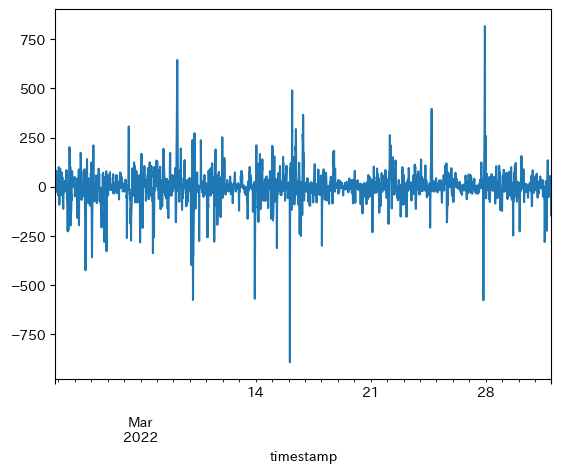

In [ ]:
# BBL_10_2.0の一次差分を可視化して確認
df["BBL_10_2.0"].diff().plot()

In [ ]:
for col in ["sma5", "sma10", "BBL_10_2.0", "BBU_10_2.0",	"BBM_10_2.0",	"ISA_9",	"ISB_26",	"ITS_9",	"IKS_26"]:
    print(f"{col}の一次差分の定常性:{adf_test(df[col].diff().dropna(), do_print=False)}")

sma5の一次差分の定常性:True
sma10の一次差分の定常性:True
BBL_10_2.0の一次差分の定常性:True
BBU_10_2.0の一次差分の定常性:True
BBM_10_2.0の一次差分の定常性:True
ISA_9の一次差分の定常性:True
ISB_26の一次差分の定常性:True
ITS_9の一次差分の定常性:True
IKS_26の一次差分の定常性:True


今回生成した特徴量に関しては階差を取ることでADF検定をパスしていることが確認できました.

### スケーリング

次はスケーリングを実施してみます.<br>
今回は各テクニカル指標を終値の値で割ることで無次元化し定常化します.(テクニカル指標の種類によっては終値の値で割っても無次元化出来ない場合があるので,利用するテクニカル指標によって方法を変える必要があります.)

<Axes: xlabel='timestamp'>

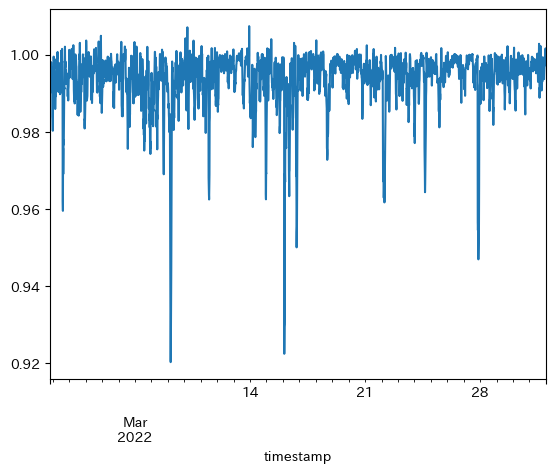

In [ ]:
(df["BBL_10_2.0"] / df["cl"]).plot()

In [ ]:
for col in ["sma5", "sma10",	"BBL_10_2.0",	"BBU_10_2.0",	"ISA_9",	"ISB_26",	"ITS_9",	"IKS_26"]:
    print(f"{col}のスケールした値の定常性:{adf_test((df[col]/df['cl']), do_print=False)}")

sma5のスケールした値の定常性:True
sma10のスケールした値の定常性:True
BBL_10_2.0のスケールした値の定常性:True
BBU_10_2.0のスケールした値の定常性:True
ISA_9のスケールした値の定常性:True
ISB_26のスケールした値の定常性:True
ITS_9のスケールした値の定常性:True
IKS_26のスケールした値の定常性:True


今回生成した特徴量に関してはcloseの値で割ることで定常化できることが確認できました.

- スケーリングにより定常化した変数を用いてrandom forestの予測を実施

テクニカル指標を適切に処理した上で特徴量として利用し, 再度random forestにより価格の変動の予測を実施します.<br>
先ほどのohlcvを用いた場合よりも予測精度が上がるかどうかを確認します.

In [ ]:
# データとラベルの用意

# 非定常な特徴量に対してcloseの値で割ることで無次元化を実施
for col in ["sma5", "sma10",	"BBL_10_2.0",	"BBU_10_2.0",	"ISA_9",	"ISB_26",	"ITS_9",	"IKS_26"]:
    df[f"scaled_{col}"] = df[col] / df["cl"]
# BBB_10_2.0, BBP_10_2.0, BBM_10_2.0は意味的に重複するので利用しないこととします.
Xy = df[["scaled_sma5", "scaled_sma10",	"scaled_BBL_10_2.0",	"scaled_BBU_10_2.0",	"scaled_ISA_9",	"scaled_ISB_26",	"scaled_ITS_9",	"scaled_IKS_26"]]
Xy["y"] = df["diff_log_close"].shift(-1)
Xy.dropna(inplace=True)
Xy.head()

scaled_sma5  scaled_sma10  scaled_BBL_10_2.0  \
timestamp                                                           
2022-03-01 19:30:00     0.999282      0.996183           0.989143   
2022-03-01 19:45:00     1.002079      0.999748           0.993514   
2022-03-01 20:00:00     0.998380      0.996423           0.990117   
2022-03-01 20:15:00     0.999740      0.997560           0.991178   
2022-03-01 20:30:00     0.998836      0.997778           0.992384   

                     scaled_BBU_10_2.0  scaled_ISA_9  scaled_ISB_26  \
timestamp                                                             
2022-03-01 19:30:00           1.003222      1.003948       1.001089   
2022-03-01 19:45:00           1.005983      1.006956       1.004088   
2022-03-01 20:00:00           1.002728      1.002850       0.999994   
2022-03-01 20:15:00           1.003942      1.003502       1.000644   
2022-03-01 20:30:00           1.003172      1.004075       0.999994   

                     scaled_ITS_9  scaled_IKS_26         y  
timestamp                                                   
2022-03-01 19:30:00      0.997298       1.002879 -0.002992  
2022-03-01 19:45:00      1.000703       1.005232  0.004086  
2022-03-01 20:00:00      0.996623       1.000786 -0.000649  
2022-03-01 20:15:00      0.997652       1.001419  0.000649  
2022-03-01 20:30:00      0.998400       1.000769  0.003967

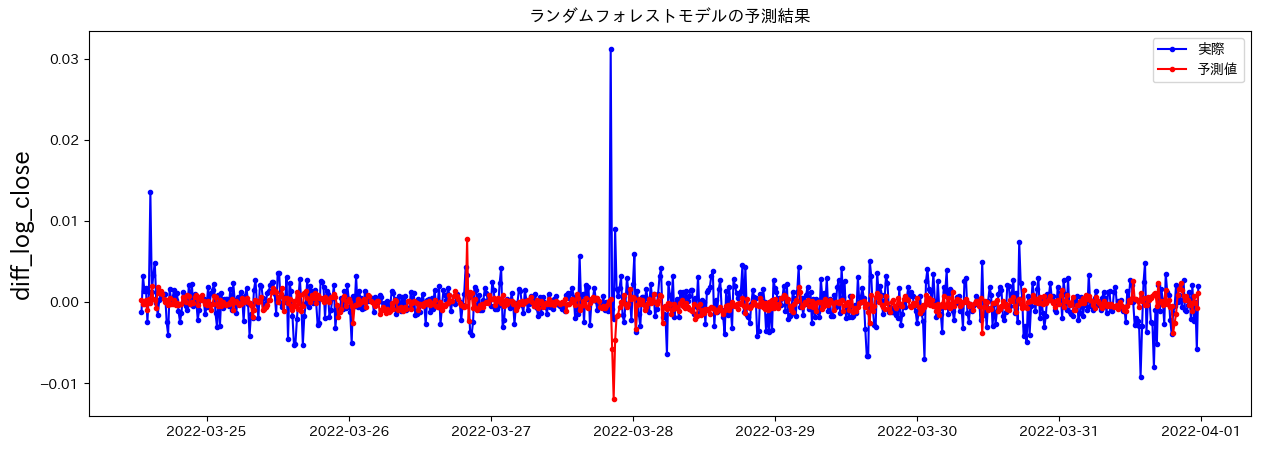

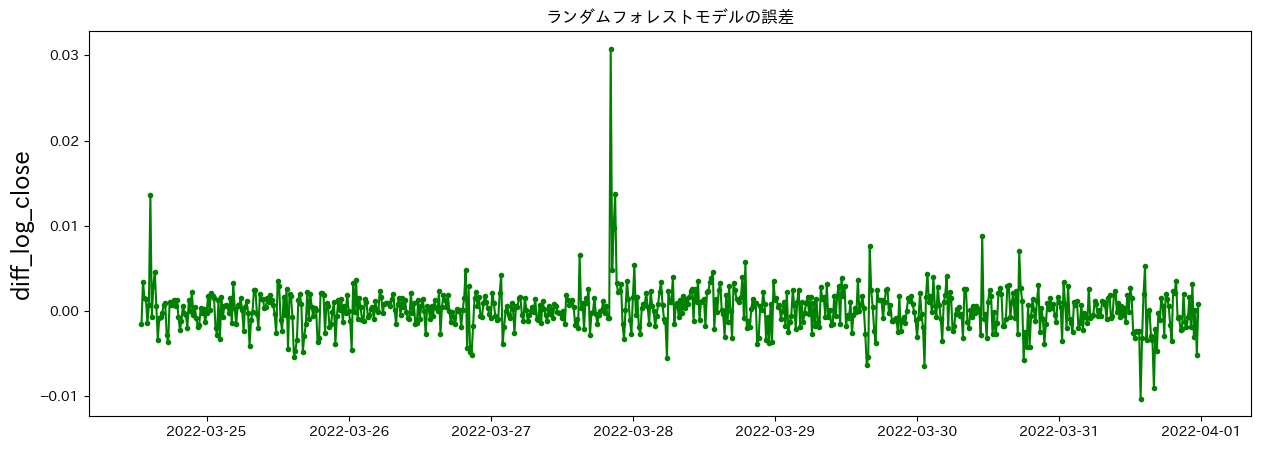

In [ ]:
# trainとvalidationを分割
trainX, trainy, valX, valy = timeseries_train_val_split(Xy, target="y")

# モデルの定義とfitting
rf = RandomForestRegressor(random_state=0)
rf.fit(trainX,trainy)
pred = rf.predict(valX)

# 可視化
plot_result(target=valy, pred= rf.predict(valX), title="ランダムフォレストモデルの予測結果", ylabel="diff_log_close")
plot_resid(valy, pred, title="ランダムフォレストモデルの誤差", ylabel="diff_log_close")

In [ ]:
# 評価
eval_direction(valy, pred)

accuracy 0.5286713286713287


ランダムフォレストモデルにおいてテクニカル指標をスケーリングにより定常化して利用した結果,
対数差分処理したohlcvのみ利用した場合より精度が向上していることを確認できました.<br>
ここでさらにテクニカル指標を追加する, モデルのパラメータチューニングを実施するなどによりさらに精度を上げることが可能なはずです.
SHAPなどの特徴量重要度を可視化する手法などを用いて,予測に対して重要な影響を持つ特徴量(テクニカル指標)を探索してみましょう.

### 分数次差分

定常化の方法として最後に分数次差分の手法を紹介します.

- 金融データの定常性とメモリについて

定常化するために差分を取る処理を実施しましたが, ここで問題になるのがメモリーの問題です.

メモリーとは価格系列データが現時点$t$に至るまでに経由してきた推移の持つ情報のことです.時系列データがどのような経路を経て現時点まで推移してきたかの情報であり, 未来推移の予測をするための予測力の元となる情報です.

取引アルゴリズムではノイズとなる情報を除外し, 取引をするためのシグナルとなる情報を抽出することを目的としています.

しかしこのメモリーが失われてしまうことでシグナルの抽出が難しくなってしまうという問題点があります.

非定常な時系列データは定常性がないため機械学習に利用できない一方, 一次差分を取った値はメモリーが失われてしまい予測が難しくなります.この問題に対処するため$0<=d<=1$となる$d$を利用した$d$次差分を取ることを考えます.

- 分数次差分の実装

節2.3.2にて$d=0$と考えた対数価格系列$logp_t$は非定常, $d=1$と考えたリターン系列$r_t$は定常であることを確認しています.

本節では$0<=d<=1$である$d$による$d$次差分を実装します.

前提となる考え方は以下の通りです.

バックシフトオペレーター$B$として, 時系列データ$X_t$に対して$k$時点前のデータ$X_{t-k}$を
$$ B^k X_t = X_{t-k}$$
で対応させる$B$を設定します.

例えば上記の式に従うと
$$B^2X_t = X_{t-2}$$
が成立します.

この$B$を用いて時系列データ$X_t$に対する差分を取る場合以下のような考え方をします.

(1) 1次差分を取る

1次差分を取った時系列データ$X_{1t}$とすると,$B$を用いて
$$X_{1t} = X_t - X_{t-1} = X_t - BX_t = (1-B)X_t$$

と表すことができます.

(2) 2次差分を取る

2次差分(1次差分の1次差分)を取った時系列データ$X_{2t}$とすると$B$を用いて
$$X_{2t}= X_{1t} - X_{1t-1} = (X_t-X_{t-1}) - (X_{t-1} - X_{t-2}) $$
$$= X_t - 2BX_t +B^2X_t = (1-B)^2X_t$$

と表すことができます.

(3) d次差分を取る

(1), (2)の場合をさらに一般化し整数とは限らない実数$d$による差分$X_{dt}$を取ることを考えると以下のような式で表すことができます.

$$X_{dt} = (1-B)^d X_t = \sum_{k=0}^{\infty}dCk (-B)^k X_t$$

- $d$次差分のウェイトの実装

上記の定義より$d$次差分は

$$
X_{dt} = X_t - dC_1 X_{t-1} + dC_2 X_{t-2} - \dots = X_t + w_1 X_{t-1} + w_2 X_{t-2} + \dots
$$

であり,
$$
w_k = (-1)^k dC_k
$$

というウェイト系列を用いることで$d$次差分を表現できます.

また式からも分かるとおり, $X_{dt}$の値は過去の時系列の情報に重み付けして和をとった値になっています.(これがd次差分が過去のメモリーを持っているということに対応します.)

ウェイトについて差分$d$を$0<=d<=2$までとし, 0.25ずつ値を変化させながら$0<=k<=5$までの範囲を可視化します.

In [ ]:
## AFML Snipet 5.1
def get_weight(d, size):
    w=[1.]
    for k in range(1,size):
        w_=-w[-1]/k * (d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w

def plot_weights(ax, d_range, nplots, size, title="d = 0~1"):
    w = pd.DataFrame()
    for d in np.linspace(d_range[0], d_range[1], nplots):
        w_ = get_weight(d,size)
        w_=pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w=w.join(w_,how='outer')
    w.plot(ax = ax)
    ax.set_title(title)
    ax.set_xlabel("k")
    ax.set_ylabel("ウェイト")
    ax.legend(loc='upper right')
    return ax

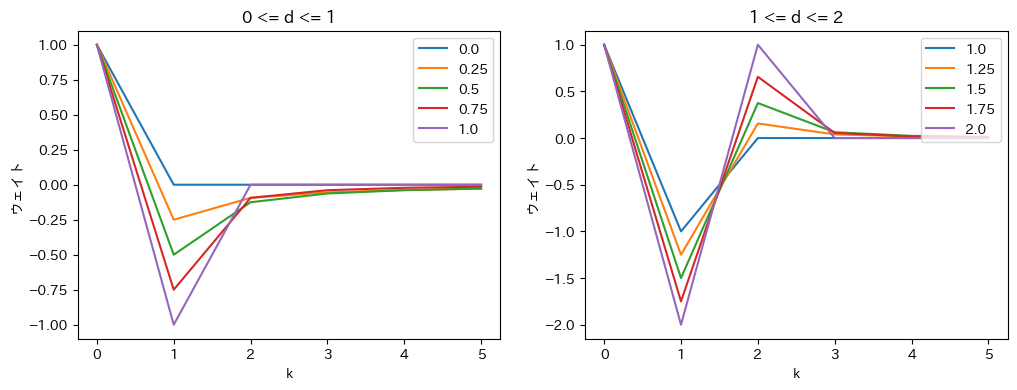

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plot_weights(ax=ax[0], d_range=[0,1],nplots=5,size=6, title="0 <= d <= 1")
plot_weights(ax=ax[1], d_range=[1,2],nplots=5,size=6, title="1 <= d <= 2")
plt.show()

$d=1$とした場合は$k>1$において$w_k=0$となり,$t-2$以前の情報が失われています.

このことが1次差分を取ることでメモリーが失われるということと対応します.

またウェイトの配列$w_d$は無限の長さをもつ配列ですが, この配列はグラフからも確認できますが0に収束します.

実際には一定以下になるウェイトの利用をしないなどの条件を設けることで利用するウェイトの個数は有限の個数になります.

この条件の設定の方法により分数次差分の実装方法が2つありますが今回は固定幅ウィンドウの方法を実装します.

- 固定幅ウィンドウ分数次差分の実装

単調減少するウェイトの絶対値の系列|$w_k$|の値が一定の閾値$\tau$を下回った場合それ以降の値を無視する方法です.

$$|w_{l^*}| >= \tau かつ |w_{l^*+1}| <= \tau$$

であるような$l^*$の値を見つけ, {$\omega_k$}について$k>l^*$についてはそのウェイトを0とすることに対応します.

この閾値$\tau$を$thres$とした固定幅ウィンドウによる分数次差分の実装fracDiff_FFDは以下のようになります.

In [ ]:
## AFML Snipet 5.3
def getWeights_FFD(d, thres):
    w, k = [1.], 1
    while True:
        w_=-w[-1]/k * (d-k+1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    return np.array(w[::-1]).reshape(-1,1)

def fracDiff_FFD(series:pd.Series, d:float, thres:float=1e-5) -> pd.DataFrame:
    """
    固定幅ウィンドウによる分数次差分の実装
    series: 価格系列データ
    d: 差分の字数
    thres: tauに対応する閾値
    """
    w= getWeights_FFD(d, thres)
    width = len(w)-1
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1-width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
        df[name] = df_.copy(deep=True)
    df=pd.concat(df, axis=1)
    return df

例として固定幅ウィンドウ分数次差分による0.5次差分の結果と元の対数価格系列を並べて確認します.

Text(0, 0.5, '0.5次差分系列')

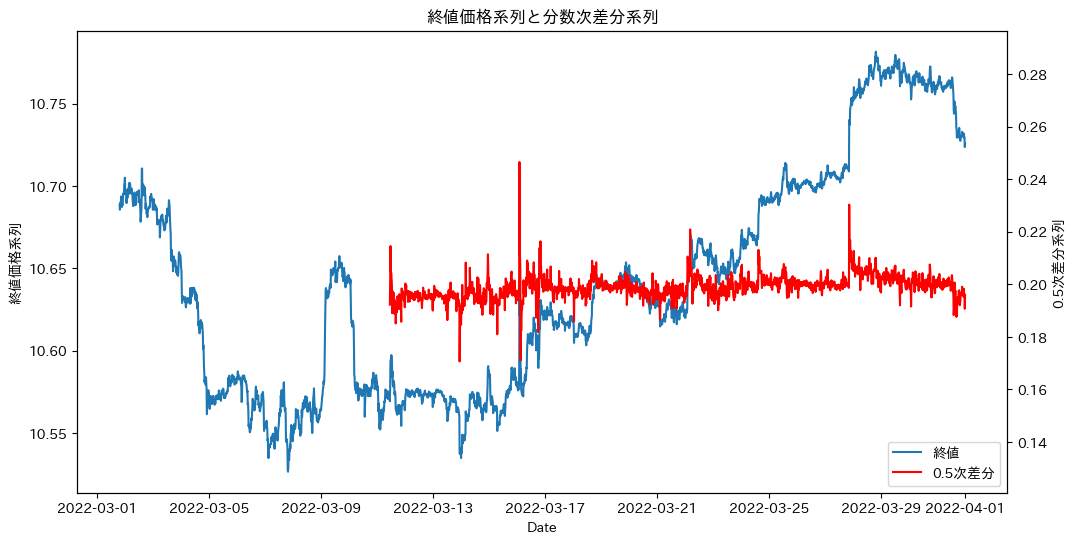

In [ ]:
plt.figure(figsize=(12,6))
plt.title("終値価格系列と分数次差分系列")

#終値系列
plt.plot(df.index, df["log_close"], label="終値")
plt.legend(loc='lower right')
plt.ylabel("終値価格系列", fontsize=10)
plt.xlabel('Date')

#軸と凡例の設定
plt.plot([],[],color='r',label='0.5次差分')
plt.legend(loc='lower right')
plt.twinx()

#0.5次差分系列
d = fracDiff_FFD(df[['log_close']], 0.5)
d.index.name="timestamp"
plt.plot(d.index, d["log_close"], color="r", label="0.5次差分")
plt.ylim([min(d["log_close"])-0.05, max(d["log_close"])+0.05])
plt.ylabel("0.5次差分系列", fontsize=10)

上記グラフより, メモリとして利用されるため初めの方の一定期間のデータは削除されることが確認できます.

- 最適な差分$d$の値の探索

$0<=d<=1$の実数$d$による差分系列は, $d$の値が1に近いほど定常課程に近づきますが, メモリーが失われてしまいます.<br>一方で0に近いほど, 元の系列に近いためメモリーを多く保持しますが定常ではない可能性があるという問題があります.<br>
そこで本節では$d$の値を0から徐々に大きくしながら, ADF検定をパスする(定常とみなすことができる)最適な$d$の値の探索を行います.

In [ ]:
def plot_min_ffd(df, col):
    """
    与えられた特徴量を分数次差分で変換する際の適切な次数を調べる関数

    Parameters
    ==========
    df: pandas dataframe
        特徴量が格納されたdataframe
    col: str
        特徴量の名前
    """
    out = pd.DataFrame(columns=['adfStat', 'pCal', 'lags', 'nobs',
                                '95% conf', 'corr'])
    d_list = np.linspace(0, 1, 11)
    for d in d_list:
        print(f'd: {d}')
        series1 = df[[col]]
        series2 = fracDiff_FFD(df[[col]], d, thres=0.01)
        corr = np.corrcoef(series1.loc[series2.index, col].values, series2.values.reshape(-1))[0, 1]
        stats = adfuller(series2.values.reshape(-1), maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(stats[:4]) + [stats[4]['5%']] + [corr]

    fig = plt.figure(figsize=(10, 7))
    ax1 = fig.add_subplot(111)
    ax1.plot(d_list, out['adfStat'].values, color='g', label='adfStats')
    ax1.hlines(np.mean(out['95% conf']), 0, 1, colors='red', linestyle='dashed', linewidth=2, label='95% conf')
    ax2 = ax1.twinx()
    ax2.plot(d_list, out['corr'].values, color='blue', label='corr')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()

    ax1.legend(h1+h2, l1+l2, loc='lower left')
    ax1.grid(axis='x')
    ax1.set_xlabel('d', size='large')
    ax1.set_ylabel('adfStats', size='large')
    ax2.set_ylabel('corr', size='large')
    ax1.set_title('次数dに対する相関とADF統計量の変化')
    plt.show()

d: 0.0
d: 0.1
d: 0.2
d: 0.30000000000000004
d: 0.4
d: 0.5
d: 0.6000000000000001
d: 0.7000000000000001
d: 0.8
d: 0.9
d: 1.0


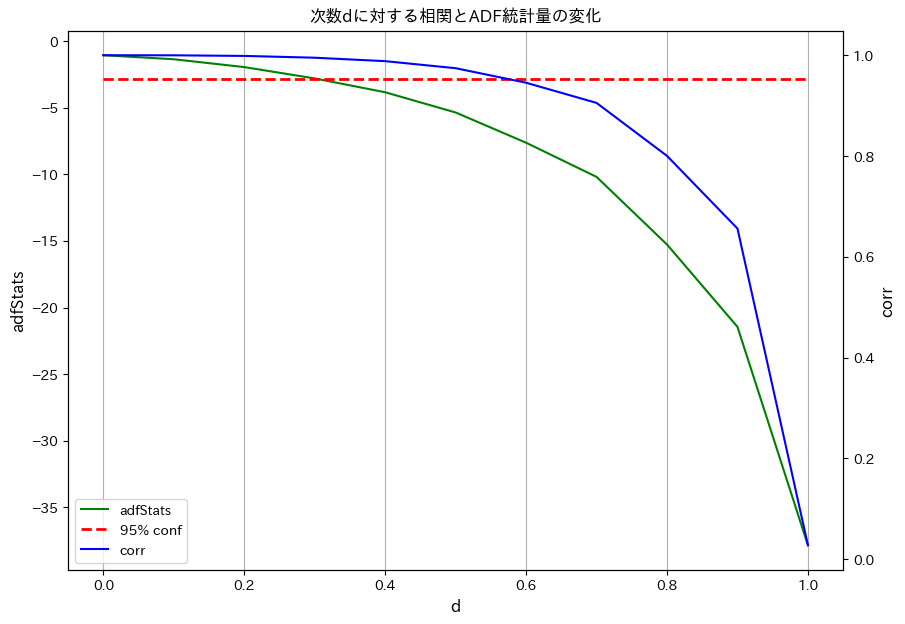

In [ ]:
plot_min_ffd(df, "log_close")

上記のグラフからdの値を大きくするにつれ元の時系列データとの相関が小さくなりADF検定の検定統計量も小さくなります.

ADF検定の有意水準を5%とするとadf検定統計量(緑色)が上記グラフの赤線を下回るときのdの値での分数次差分が定常であるなかで最も多く元系列のメモリーを保持しているということになります.

今回の例では$d=0.3$付近が条件を満たす最小の$d$であることがわかります.

### その他の方法

上記以外にもLSTMの例で実施したような標準化のような方法が考えられます.

### 定常化の方法に関するまとめ

定常化の方法として

- 階差
- スケーリング
- 分数次差分
- 標準化

について紹介しました.<br>
それぞれの特徴と実用性という点でまとめると次のようになります.利用する分析モデルや処理速度などを踏まえて適切な方法による定常化を行うことが重要です.

| 手法 | 概要 | 特徴 |
| --- | --- | --- |
| 階差 | データに対して差分を取る処理 | 実装が非常に簡単な一方, メモリが失われる問題が挙げられているため,<br>他の方法の方が好ましい可能性が高い. |
| スケーリング | 終値で割り特徴量を無次元化する | 特徴量によっては終値で割るだけでは無次元化されないため, <br>個別の特徴量について確認が必要. |
| 分数次差分 | 系列データのメモリを保持するように<br>1次以下の差分を取る | メモリを保持しつつ,定常化することが可能.<br>一方, 実装が多く処理も重たくなるため実用上利用するべきかは検討が必要. |
| 標準化 | データの平均を0, 分散を1にする処理 | 時系列データであるため, 先読みに注意した前処理が必要. <br> 実装が容易だが, 定常化されているかどうかについては確認が必要. |

# 練習問題

目標：
ohlcv形式のタイムバーから機械学習の入力データとして利用できるテーブルデータ$X$を作成する関数preprocessを実装する.<br>
random forestの予測精度をさらに向上させる特徴量を作成する.

## 事前準備

演集に必要なデータを再度準備します.

In [ ]:
# ADF検定用パッケージ
from statsmodels.tsa.stattools import adfuller

In [ ]:
import pandas_ta as ta

In [ ]:
# time_barテーブルの読み込み(場合によってはファイルへのパスを変更していただく必要があります.)
# こちらのpickleファイルはDay02フォルダ以下に配置されているものです.
with open("./bybit_BTCUSD_2022_3_time_bar.pkl", mode="rb") as f:
    time_bar = pickle.load(f)
# time_bar["timestamp"] = pd.to_datetime(time_bar["timestamp"], unit="s")
# time_bar.set_index("timestamp", inplace=True)
time_bar.head()

op       hi       lo       cl    volume
timestamp                                                        
2022-03-01 00:00:00  43179.5  43593.0  43177.0  43367.0  39018957
2022-03-01 00:15:00  43367.0  43384.0  43198.5  43367.0   9372331
2022-03-01 00:30:00  43367.5  43541.5  43318.5  43524.5  22522912
2022-03-01 00:45:00  43524.5  43745.0  43341.5  43549.5  27202334
2022-03-01 01:00:00  43549.5  43620.0  43279.0  43294.0  13692174

## 演習

本演習では関数preprocessの実装を目標としています.

ohlcvのタイムバーデータに対して分析に利用できる形に変形する一連の処理を実装します.

流れとしては,

1. talibやpandas-taなどのライブラリをもとにテクニカル指標を作成する

2. 非定常な指標に対して適切な方法で定常化する(分数次差分や,スケーリングなど)

となります.

この関数は最終課題であるコンペティションで利用できるようなものを想定しています.

## 練習問題1

系列データの定常性を確認する関数adf_testを実装しましょう.

In [ ]:
# ADF検定用パッケージ
from statsmodels.tsa.stattools import adfuller

def adf_test(df: pd.Series) -> bool:
    """
    入力された系列データの定常性を検定する

    Args:
        df (pd.DataFrame) : 系列データ

    Returns:
        bool : 定常か否かのbool値
    """
    # adfullerを用いて,入力dfに対するadf検定を実施します.
    ### write me ###

## 練習問題2

ohlcvから特徴量を作成してみましょう.

In [ ]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    """
    テクニカル指標を計算し,新たな列として追加する関数

    Args:
        df(pd.DataFrame) : ohlcv形式タイムバー

    Returns:
        new_df: pd.DataFrame
        テクニカル指標が列に追加されたテーブル
    """
    new_df = df.copy()
    close = new_df['cl']
    ### 例 ###
    new_df['SMA10'] = ta.sma(close, length=10)
    ### さまざまなテクニカル指標の作成を試してみましょう. ###
    return new_df

In [ ]:
# 特徴量の定常性の確認
X = preprocess(time_bar)
for col in X.columns:
  print(f"{col}の定常性: {adf_test(X[col])}")

定常性の確認のほか、plotして分布を確認してみる,過去からの累積和のような特徴量になっていないかを確認するということも重要です.

## 練習問題3

特徴量に対して定常化の処理を実施し,分析に利用できるデータを作成しましょう.

In [ ]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    """
    テクニカル指標を計算し,新たな列として追加する関数

    Args:
        df(pd.DataFrame) : ohlcv形式タイムバー

    Returns:
        new_df: pd.DataFrame
        テクニカル指標が列に追加されたテーブル
    """
    new_df = df.copy(
    close = new_df['close']
    ### 例 ###
    new_df['SMA10'] = ta.sma(close, length=10) / close
    ### 練習問題2で作成した特徴量に対してスケーリングや分数次差分による定常化を試しましょう. ###
    return new_df

In [ ]:
# 特徴量の定常性の確認
X = preprocess(time_bar)
for col in X.columns:
    print(f"{col}の定常性: {adf_test(X[col])}")

## 解答例

In [ ]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    """
    テクニカル指標を計算し,新たな列として追加する関数

    Args:
        df(pd.DataFrame) : ohlcv形式タイムバー

    Returns:
        new_df: pd.DataFrame
        テクニカル指標が列に追加されたテーブル
    """
    open, high, low, close, volume = df["op"], df["hi"], df["lo"], df["cl"], df["volume"]
    ichimoku_visible, _ = ta.ichimoku(high, low, close)
    df["ISA_9"] = ichimoku_visible["ISA_9"] /close # spanA
    df["ISB_26"] = ichimoku_visible["ISB_26"] /close # spanB
    df["ITS_9"] = ichimoku_visible["ITS_9"] /close # 転換線
    df["IKS_26"] = ichimoku_visible["IKS_26"] /close # 基準線

    bbands = ta.bbands(close, length=10)
    df["BBL_10_2.0"] = bbands["BBL_10_2.0"]  /close # 下の線
    df["BBU_10_2.0"] = bbands["BBU_10_2.0"] /close # 上の線

    df["ema5"] = ta.ema(close, 5) /close
    df["ema10"] = ta.ema(close, 10)/close

    df["sma5"] = ta.sma(close, 5)/close
    df["sma10"] = ta.sma(close, 10)/close

    df["MIDPOINT"] = ta.midpoint(close, timeperiod=16) / close
    df["T3"] = ta.t3(close, timeperiod=4, vfactor=0) / close
    df["TEMA"] = ta.tema(close, timeperiod=24) / close
    df["TRIMA"] = ta.trima(close, timeperiod=24) / close

    df["MFI"] = ta.mfi(high, low, close, volume, timeperiod=16)

    df["APO"] = ta.apo(close, fastperiod=12, slowperiod=26, matype=0)

    df["WILLR"] = ta.willr(high, low, close, timeperiod=16)

    df["ATR"] = ta.atr(high, low, close, timeperiod=16)
    df["NATR"] = ta.natr(high, low, close, timeperiod=1)
    return df.drop(["op", "hi", "lo", "cl", "volume"], axis=1).dropna()

In [ ]:
# 特徴量の定常性の確認
X = preprocess(time_bar.copy())
for col in X.columns:
    print(f"{col}の定常性: {adf_test(X[col])}")

Results of Dickey-Fuller Examination:
Test Statistic                -6.802095e+00
p-value                        2.223710e-09
#Lags Used                     2.800000e+01
Number of Observations Used    2.870000e+03
dtype: float64
ISA_9の定常性: True
Results of Dickey-Fuller Examination:
Test Statistic                   -5.503627
p-value                           0.000002
#Lags Used                       26.000000
Number of Observations Used    2872.000000
dtype: float64
ISB_26の定常性: True
Results of Dickey-Fuller Examination:
Test Statistic                -1.351065e+01
p-value                        2.857699e-25
#Lags Used                     1.100000e+01
Number of Observations Used    2.887000e+03
dtype: float64
ITS_9の定常性: True
Results of Dickey-Fuller Examination:
Test Statistic                -7.653531e+00
p-value                        1.763445e-11
#Lags Used                     2.600000e+01
Number of Observations Used    2.872000e+03
dtype: float64
IKS_26の定常性: True
Results of Dickey-Full

In [ ]:
# random forestによるdiff_log_closeの予測
Xy = X.copy()
Xy["y"] = np.log(time_bar["cl"]).diff().shift(-1)
Xy.dropna(inplace=True)
Xy.head()

ISA_9    ISB_26     ITS_9    IKS_26  BBL_10_2.0  \
timestamp                                                                 
2022-03-01 19:15:00  0.998206  0.995763  0.994938  1.003009    0.985842   
2022-03-01 19:30:00  1.003948  1.001089  0.997298  1.002879    0.989143   
2022-03-01 19:45:00  1.006956  1.004088  1.000703  1.005232    0.993514   
2022-03-01 20:00:00  1.002850  0.999994  0.996623  1.000786    0.990117   
2022-03-01 20:15:00  1.003502  1.000644  0.997652  1.001419    0.991178   

                     BBU_10_2.0      ema5     ema10      sma5     sma10  \
timestamp                                                                 
2022-03-01 19:15:00    1.000046  0.996025  0.994585  0.995450  0.992944   
2022-03-01 19:30:00    1.003222  0.998925  0.997499  0.999282  0.996183   
2022-03-01 19:45:00    1.005983  1.001279  1.000399  1.002079  0.999748   
2022-03-01 20:00:00    1.002728  0.998131  0.996989  0.998380  0.996423   
2022-03-01 20:15:00    1.003942  0.999186  0.998067  0.999740  0.997560   

                     MIDPOINT        T3      TEMA     TRIMA        MFI  \
timestamp                                                                
2022-03-01 19:15:00  0.997264  0.990349  0.997572  0.992110  68.840623   
2022-03-01 19:30:00  1.001186  0.993299  1.000651  0.995459  63.646434   
2022-03-01 19:45:00  1.001498  0.996950  1.002684  0.999468  53.429358   
2022-03-01 20:00:00  0.997961  0.993636  0.999718  0.996312  62.419997   
2022-03-01 20:15:00  1.000325  0.995072  1.000754  0.997694  78.047409   

                            APO      WILLR         ATR      NATR         y  
timestamp                                                                   
2022-03-01 19:15:00 -249.000000 -16.399083  269.515992  0.560861 -0.002369  
2022-03-01 19:30:00 -185.657051 -28.325688  262.349868  0.538769 -0.002992  
2022-03-01 19:45:00 -127.131410 -40.517760  256.988077  0.525512  0.004086  
2022-03-01 20:00:00  -69.416667 -18.964479  258.707793  0.538931 -0.000649  
2022-03-01 20:15:00  -14.612179 -23.754789  255.363254  0.531807  0.000649

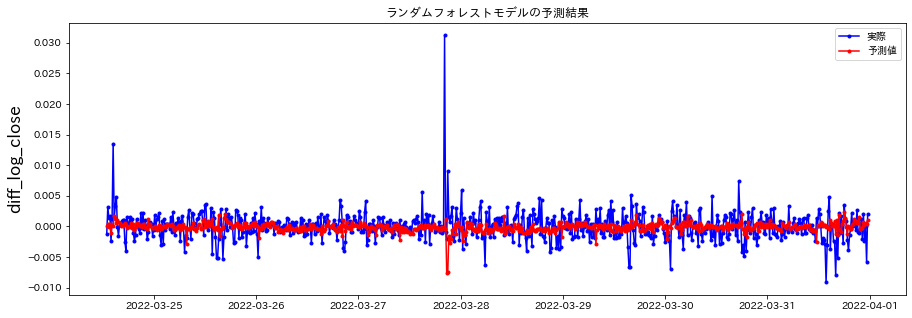

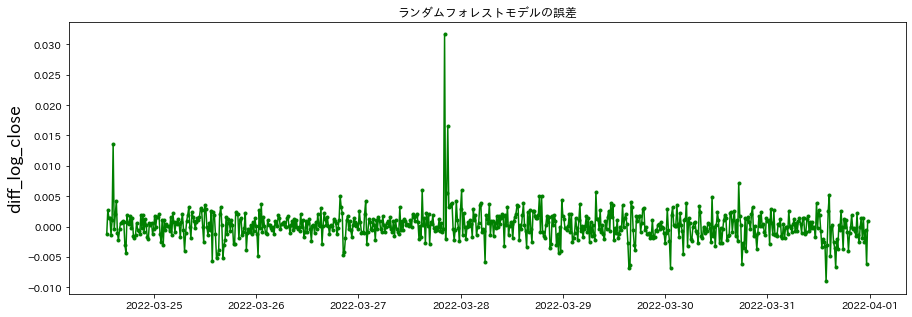

In [ ]:
# trainとvalidationを分割
trainX, trainy, valX, valy = timeseries_train_val_split(Xy, target="y")

# モデルの定義とfitting
rf = RandomForestRegressor(random_state=0)
rf.fit(trainX,trainy)
pred = rf.predict(valX)

# 可視化
plot_result(target=valy, pred=pred, title="ランダムフォレストモデルの予測結果", ylabel="diff_log_close")
plot_resid(valy, pred, title="ランダムフォレストモデルの誤差", ylabel="diff_log_close")

In [ ]:
# 評価
eval_direction(valy, pred)

accuracy 0.5244755244755245
